In [1]:
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
import dask.array as da
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
import timeit
from dask import delayed
import pandas as pd
import numpy as np

pd.set_option('max_columns', None)
pd.set_option('max_rows',250)

In [2]:
#close existing dask connection if it exists and open a new one
try:
    if client is not None:
        client.close()
        print("closed existing connection, ",client)       
except Exception as e:
    print(e)


name 'client' is not defined


In [3]:
#get new connection
client = Client(n_workers=2, threads_per_worker=2, memory_limit='8GB')
display(client)

Client Scheduler: tcp://127.0.0.1:51983 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 14.90 GiB


# Reading from CSV Files with a 'glob' by using wild character in the filename allowing parallel processing by dask

In [4]:
%%time 
games_data = dd.read_csv('data/Datasets_mbb_games_sr*.csv', dtype={'a_assists': 'float64', 'a_blocked_att': 'float64','a_blocks': 'float64',\
                                                                             'a_coach_tech_fouls': 'float64','a_defensive_rebounds': 'float64',\
                                                                             'a_ejections': 'float64','a_field_goals_att': 'float64','a_field_goals_made': 'float64',\
                                                                             'a_flagrant_fouls': 'float64','a_free_throws_att': 'float64',\
                                                                             'a_free_throws_made': 'float64','a_offensive_rebounds': 'float64',\
                                                                             'a_personal_fouls': 'float64','a_player_tech_fouls': 'float64',\
                                                                             'a_points': 'float64','a_rebounds': 'float64',\
                                                                             'a_steals': 'float64','a_team_rebounds': 'float64','a_team_tech_fouls': 'float64',\
                                                                             'a_team_turnovers': 'float64','a_three_points_att': 'float64',\
                                                                             'a_three_points_made': 'float64','a_turnovers': 'float64','a_two_points_att': 'float64',\
                                                                             'a_two_points_made': 'float64','attendance': 'float64','h_assists': 'float64',\
                                                                             'h_blocked_att': 'float64','h_blocks': 'float64','h_coach_tech_fouls': 'float64',\
                                                                             'h_defensive_rebounds': 'float64','h_ejections': 'float64',\
                                                                             'h_field_goals_att': 'float64','h_field_goals_made': 'float64',\
                                                                             'h_flagrant_fouls': 'float64','h_free_throws_att': 'float64',\
                                                                             'h_free_throws_made': 'float64','h_offensive_rebounds': 'float64',\
                                                                             'h_personal_fouls': 'float64','h_player_tech_fouls': 'float64','h_points': 'float64',\
                                                                             'h_rebounds': 'float64','h_steals': 'float64','h_team_rebounds': 'float64',\
                                                                             'h_team_tech_fouls': 'float64','h_team_turnovers': 'float64',\
                                                                             'a_points_game': 'float64','h_points_game': 'float64','season': 'float64','h_rank': 'float64','a_rank': 'float64',\
                                                                             'h_three_points_att': 'float64','h_three_points_made': 'float64',\
                                                                             'h_turnovers': 'float64','h_two_points_att': 'float64','h_two_points_made': 'float64',\
                                                                             'periods': 'float64','venue_capacity': 'float64','venue_zip': 'object'}, parse_dates=['scheduled_date'])
player_game_data = dd.read_csv('data/Datasets_mbb_players_games_sr*.csv', assume_missing=True)
#player_game_data = dd.read_csv('gcs://sportsdata641/Datasets/mbb_players_games_sr', assume_missing=True)

Wall time: 200 ms


In [5]:
player_game_data

,game_id,season,neutral_site,scheduled_date,gametime,tournament,tournament_type,tournament_round,tournament_game_no,player_id,last_name,first_name,full_name,abbr_name,status,jersey_number,height,weight,birth_place,birthplace_city,birthplace_state,birthplace_country,class,team_name,team_market,team_id,team_alias,conf_name,conf_alias,division_name,division_alias,league_name,home_team,active,played,starter,minutes,minutes_int64,position,primary_position,field_goals_made,field_goals_att,field_goals_pct,three_points_made,three_points_att,three_points_pct,two_points_made,two_points_att,two_points_pct,blocked_att,free_throws_made,free_throws_att,free_throws_pct,offensive_rebounds,defensive_rebounds,rebounds,assists,turnovers,steals,blocks,assists_turnover_ratio,personal_fouls,tech_fouls,flagrant_fouls,points,sp_created
npartitions=7,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,bool,bool,bool,bool,object,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [6]:
#Replace NaN values with mean and 0
m_vals = player_game_data[['height','weight']].mean(skipna=True).compute()
z_vals = pd.Series([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], index=['minutes_int64','field_goals_made','field_goals_att','field_goals_pct','three_points_made', 'three_points_att','three_points_pct', 'two_points_made',    'two_points_att', 'two_points_pct',\
                                   'blocked_att','free_throws_made','free_throws_att','free_throws_pct','offensive_rebounds','defensive_rebounds','rebounds','assists','turnovers','steals','blocks','assists_turnover_ratio',\
                                   'personal_fouls','tech_fouls','flagrant_fouls','points'])
#m_vals.append(z_vals)
pgdf = player_game_data.fillna(value = m_vals.append(z_vals))

In [7]:
# NaN values in Attendance are replaced with mean attendance of the home team. Have to convert to pandas
attendance_m = pd.DataFrame(games_data.groupby('h_name').attendance.mean().round().compute()) # convert to pandas
attendance_m.fillna(0, inplace=True)
def get_attendance(hn):
    if hn is None:
        return 0
    else:
        return attendance_m.loc[hn]

In [8]:
gdf = games_data.compute()
gdf['attendance'] = gdf['h_name'].apply(lambda hn: get_attendance(hn))
gdf.columns

Index(['game_id', 'season', 'status', 'coverage', 'neutral_site',
       'scheduled_date', 'gametime', 'conference_game', 'tournament',
       'tournament_type',
       ...
       'a_fast_break_pts', 'a_second_chance_pts', 'a_team_turnovers',
       'a_points_off_turnovers', 'a_team_rebounds', 'a_flagrant_fouls',
       'a_player_tech_fouls', 'a_team_tech_fouls', 'a_coach_tech_fouls',
       'created'],
      dtype='object', length=132)

In [9]:
z_gvals = pd.Series([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], index=['lead_changes', 'times_tied','periods','h_field_goals_made','h_field_goals_att','h_field_goals_pct','h_three_points_made','h_three_points_att','h_three_points_pct',\
                                                                                  'h_two_points_made','h_two_points_att','h_two_points_pct','h_blocked_att','h_free_throws_made','h_free_throws_att','h_free_throws_pct','h_offensive_rebounds','h_defensive_rebounds',\
                                                                                  'h_rebounds','h_assists','h_turnovers','h_steals','h_blocks','h_assists_turnover_ratio','h_personal_fouls','h_ejections','h_foulouts','h_points','h_fast_break_pts','h_second_chance_pts',\
                                                                                  'h_team_turnovers','h_points_off_turnovers','h_team_rebounds','h_flagrant_fouls','h_player_tech_fouls','h_team_tech_fouls','h_coach_tech_fouls','a_field_goals_made','a_field_goals_att',\
                                                                                  'a_field_goals_pct','a_three_points_made','a_three_points_att','a_three_points_pct','a_two_points_made','a_two_points_att','a_two_points_pct','a_blocked_att','a_free_throws_made','a_free_throws_att',\
                                                                                  'a_free_throws_pct','a_offensive_rebounds','a_defensive_rebounds','a_rebounds','a_assists','a_turnovers','a_steals','a_blocks','a_assists_turnover_ratio','a_personal_fouls','a_ejections','a_foulouts',\
                                                                                  'a_points','a_fast_break_pts','a_second_chance_pts',\
                                                                                  'a_team_turnovers','a_points_off_turnovers','a_team_rebounds','a_flagrant_fouls','a_player_tech_fouls','a_team_tech_fouls','a_coach_tech_fouls'])

#converting back to dask dataframe
games_data = dd.from_pandas(gdf,npartitions=2)
games_data = games_data.dropna(thresh = 65)
# Margin of Victory column
games_data['MOV'] = (games_data['h_points_game']-games_data['a_points_game'])

gddf = games_data.fillna(value = z_gvals)


In [10]:
#Merging with game table
#dfm = gddf.merge(pgdf.groupby('game_id').mean(), how='inner', on='game_id')
dfm = (gddf.merge(pgdf.groupby(['game_id','home_team']).mean().query('home_team == True')[['height','weight','minutes_int64']],\
                  how='inner', on='game_id').merge\
    (pgdf.groupby(['game_id','home_team']).mean().query('home_team == False')[['height','weight','minutes_int64']], \
     how='inner', on='game_id', suffixes=('_h','_a')))

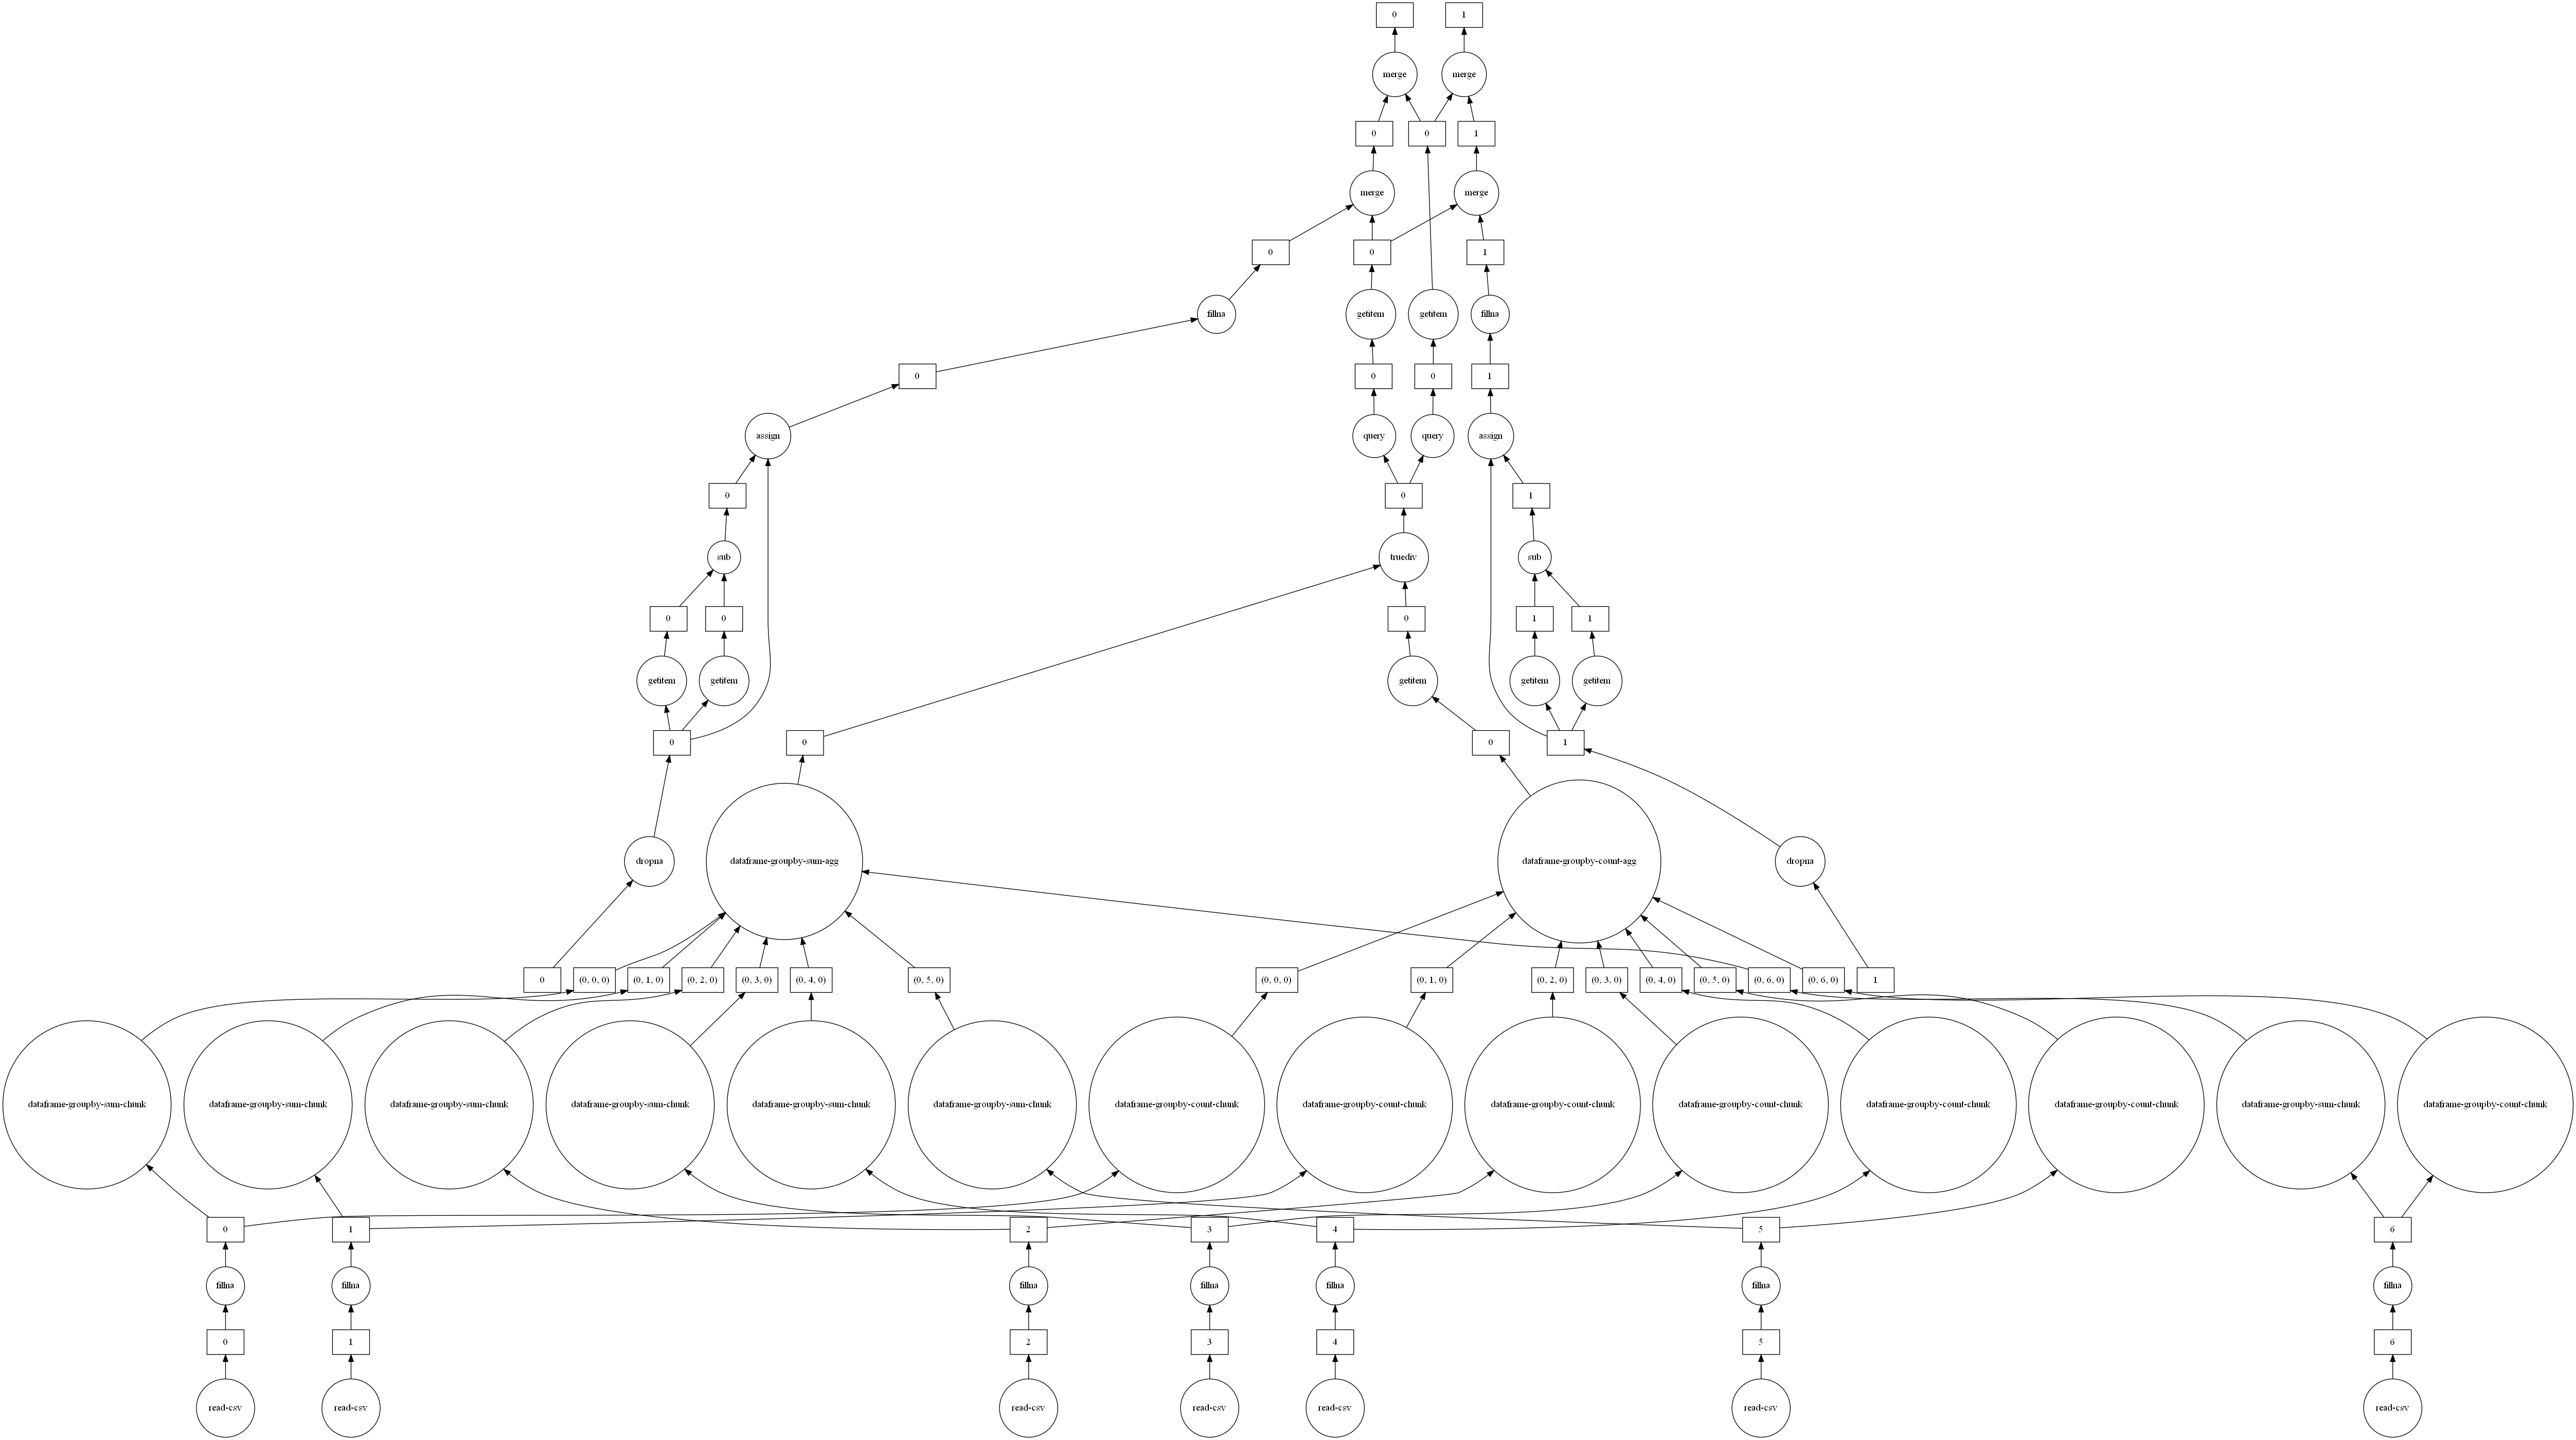

In [11]:
dfm.visualize()

In [12]:
%%time
cln = dfm.set_index('game_id').compute()

Wall time: 24.7 s


In [13]:
#cln['a_division_alias' == 'D1']
#cln = cln[(cln['a_division_alias'] == 'D1') & (cln['h_division_alias'] == 'D1')]

In [14]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
cln['a_div'] = enc.fit_transform(cln['a_division_alias'].astype('str'))
cln['h_div'] = enc.fit_transform(cln['h_division_alias'].astype('str'))

In [15]:
cln.describe()

,season,neutral_site,attendance,lead_changes,times_tied,periods,venue_capacity,h_points_game,h_rank,h_field_goals_made,h_field_goals_att,h_field_goals_pct,h_three_points_made,h_three_points_att,h_three_points_pct,h_two_points_made,h_two_points_att,h_two_points_pct,h_blocked_att,h_free_throws_made,h_free_throws_att,h_free_throws_pct,h_offensive_rebounds,h_defensive_rebounds,h_rebounds,h_assists,h_turnovers,h_steals,h_blocks,h_assists_turnover_ratio,h_personal_fouls,h_ejections,h_foulouts,h_points,h_fast_break_pts,h_second_chance_pts,h_team_turnovers,h_points_off_turnovers,h_team_rebounds,h_flagrant_fouls,h_player_tech_fouls,h_team_tech_fouls,h_coach_tech_fouls,a_points_game,a_rank,a_field_goals_made,a_field_goals_att,a_field_goals_pct,a_three_points_made,a_three_points_att,a_three_points_pct,a_two_points_made,a_two_points_att,a_two_points_pct,a_blocked_att,a_free_throws_made,a_free_throws_att,a_free_throws_pct,a_offensive_rebounds,a_defensive_rebounds,a_rebounds,a_assists,a_turnovers,a_steals,a_blocks,a_assists_turnover_ratio,a_personal_fouls,a_ejections,a_foulouts,a_points,a_fast_break_pts,a_second_chance_pts,a_team_turnovers,a_points_off_turnovers,a_team_rebounds,a_flagrant_fouls,a_player_tech_fouls,a_team_tech_fouls,a_coach_tech_fouls,MOV,height_h,weight_h,minutes_int64_h,height_a,weight_a,minutes_int64_a,a_div,h_div
count,24999.000000,11944.000000,24999.000000,24999.000000,24999.000000,24999.000000,24881.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.000000,24999.00000
mean,2015.341734,0.113279,5368.560902,4.114205,3.173047,2.071843,9369.088341,74.551742,1.340654,25.908756,56.969519,45.551438,7.261450,20.372935,35.451258,18.647306,36.596584,29.140492,1.392616,15.464139,21.901956,70.434137,9.217009,24.045602,33.262611,14.265091,11.983159,6.412857,3.907876,1.349132,17.795592,0.000560,0.053682,74.546102,6.494060,10.688668,0.283411,14.816193,3.025761,0.012961,0.089724,0.014481,0.009480,68.106924,0.875595,24.065203,57.019521,42.355586,6.881355,20.379215,33.678311,17.183847,36.640306,26.598665,1.889476,13.044442,18.767271,69.095792,8.631185,22.142846,30.774031,12.033801,12.947878,5.869995,2.947838,1.052834,19.527661,0.000680,0.085083,68.058802,5.056682,9.682067,0.365735,12.609664,3.242330,0.022521,0.096884,0.019161,0.014201,6.444818,76.936253,203.791519,13.422580,76.005315,198.992960,13.358747,2.110604,0.00120
std,1.269721,0.316946,4016.255365,4.343817,3.298904,0.326263,6005.944244,13.050982,4.555693,5.275758,7.640810,7.421369,3.176107,6.048197,11.452234,4.913962,7.494801,26.534236,2.093344,6.251463,8.121021,11.740769,3.819994,5.315842,6.884248,4.708123,3.792987,2.993980,2.437234,0.803805,4.300272,0.026828,0.274963,13.087941,5.389252,5.759536,0.612006,6.733311,2.036740,0.114861,0.389258,0.124063,0.100155,12.327522,3.769751,4.795880,7.736191,7.498320,3.018823,6.117731,11.284336,4.575329,7.510213,24.371147,2.692227,5.798982,7.512227,13.297012,3.622296,4.942735,6.308972,4.041946,4.160075,2.722560,2.048632,0.592754,4.640723,0.038466,0.355431,12.485501,4.502058

# Feature Selection

In [16]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import joblib

features = [
            #'minutes_int64_h','minutes_int64_a',
            'attendance','lead_changes', 'times_tied','periods',\
            #'h_field_goals_made','h_field_goals_att',\
            #'h_field_goals_pct',\
            'h_three_points_made','h_three_points_att',\
            #'h_three_points_pct',\
            'h_two_points_made','h_two_points_att',
            #'h_two_points_pct','h_blocked_att',\
            'h_free_throws_made','h_free_throws_att','h_personal_fouls',\
            #'h_free_throws_pct','h_offensive_rebounds','h_defensive_rebounds',\
            'h_rebounds','h_assists','h_turnovers','h_steals','h_blocks','h_ejections','h_flagrant_fouls',\
            #'h_assists_turnover_ratio','h_foulouts',\
            #'h_points',
            #'h_fast_break_pts','h_second_chance_pts',\
            #'h_team_turnovers','h_points_off_turnovers','h_team_rebounds','h_player_tech_fouls',\
            #'h_team_tech_fouls','h_coach_tech_fouls',\
            #'a_field_goals_made','a_field_goals_att',\
            #'a_field_goals_pct',\
            'a_three_points_made','a_three_points_att',\
            #'a_three_points_pct',\
            'a_two_points_made','a_two_points_att',\
            #'a_two_points_pct','a_blocked_att',\
            'a_free_throws_made','a_free_throws_att','a_personal_fouls',\
            #'a_free_throws_pct',\
            #'a_offensive_rebounds','a_defensive_rebounds',\
            'a_rebounds','a_assists','a_turnovers','a_steals','a_blocks','a_ejections','a_flagrant_fouls',\
            #'a_assists_turnover_ratio','a_foulouts',\
            #'a_points',
            #'a_fast_break_pts','a_second_chance_pts',\
            'a_div','h_div','height_h', 'weight_h','height_a','weight_a',\
            #'a_team_turnovers','a_points_off_turnovers',\
            #'a_team_rebounds','a_player_tech_fouls','a_team_tech_fouls','a_coach_tech_fouls'\
           ]

rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=38, step=0.1, verbose=5)
with joblib.parallel_backend('dask'):
    rfe_selector.fit(cln[features], cln['MOV'])
rfe_support = rfe_selector.get_support()
rfe_feature = cln[features].loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
display(rfe_feature)

38 selected features


['attendance',
 'lead_changes',
 'times_tied',
 'periods',
 'h_three_points_made',
 'h_three_points_att',
 'h_two_points_made',
 'h_two_points_att',
 'h_free_throws_made',
 'h_free_throws_att',
 'h_personal_fouls',
 'h_rebounds',
 'h_assists',
 'h_turnovers',
 'h_steals',
 'h_blocks',
 'h_ejections',
 'h_flagrant_fouls',
 'a_three_points_made',
 'a_three_points_att',
 'a_two_points_made',
 'a_two_points_att',
 'a_free_throws_made',
 'a_free_throws_att',
 'a_personal_fouls',
 'a_rebounds',
 'a_assists',
 'a_turnovers',
 'a_steals',
 'a_blocks',
 'a_ejections',
 'a_flagrant_fouls',
 'a_div',
 'h_div',
 'height_h',
 'weight_h',
 'height_a',
 'weight_a']

# PCA

In [17]:
from dask_ml.decomposition import PCA
from dask_ml import preprocessing
from dask_ml.preprocessing import StandardScaler

cln_new = cln[rfe_feature]
display(cln_new.shape)
#converting pandas df to dask df
ddX = dd.from_pandas(cln_new,npartitions=3)
#converting dask df to dask array for PCA
daX = ddX.to_dask_array(lengths=True)
#creating PCA object
pca = PCA(n_components=38,svd_solver='auto')
#transformed data
daX_new = pca.fit_transform(daX)
#converting dask array back to dask dataframe
ddX_new = dd.from_dask_array(daX_new)
#converting to pandas df
pdX = ddX_new.compute()
display(pdX.shape)
#pca.explained_variance_
#pca.components_

(24999, 38)

(24999, 38)

features = ['minutes_int64','attendance','field_goals_made','field_goals_att','field_goals_pct','three_points_made', 'three_points_att','three_points_pct', 'two_points_made',    'two_points_att', 'two_points_pct',\
            'blocked_att','free_throws_made','free_throws_att','free_throws_pct','offensive_rebounds','defensive_rebounds','rebounds','assists','turnovers','steals','blocks','assists_turnover_ratio',\
            'personal_fouls','tech_fouls','flagrant_fouls','points','lead_changes', 'times_tied','periods','h_field_goals_made','h_field_goals_att','h_field_goals_pct','h_three_points_made','h_three_points_att','h_three_points_pct',\
            'h_two_points_made','h_two_points_att','h_two_points_pct','h_blocked_att','h_free_throws_made','h_free_throws_att','h_free_throws_pct','h_offensive_rebounds','h_defensive_rebounds',\
            'h_rebounds','h_assists','h_turnovers','h_steals','h_blocks','h_assists_turnover_ratio','h_personal_fouls','h_ejections','h_foulouts','h_points','h_fast_break_pts','h_second_chance_pts',\
            'h_team_turnovers','h_points_off_turnovers','h_team_rebounds','h_flagrant_fouls','h_player_tech_fouls','h_team_tech_fouls','h_coach_tech_fouls','a_field_goals_made','a_field_goals_att',\
            'a_field_goals_pct','a_three_points_made','a_three_points_att','a_three_points_pct','a_two_points_made','a_two_points_att','a_two_points_pct','a_blocked_att','a_free_throws_made','a_free_throws_att',\
            'a_free_throws_pct','a_offensive_rebounds','a_defensive_rebounds','a_rebounds','a_assists','a_turnovers','a_steals','a_blocks','a_assists_turnover_ratio','a_personal_fouls','a_ejections','a_foulouts',\
            'a_points','a_fast_break_pts','a_second_chance_pts',\
            'a_div','h_div',\
            'a_team_turnovers','a_points_off_turnovers','a_team_rebounds','a_flagrant_fouls','a_player_tech_fouls','a_team_tech_fouls','a_coach_tech_fouls']

In [18]:
X = pdX    # w/ PCA & RFE
#X = cln[features]
Y = cln['MOV']

In [19]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,-4208.555395,10.248634,13.740033,-5.216003,-5.165363,-14.092302,-1.695865,-8.095414,-12.532949,10.212044,5.070965,-2.196908,-0.760734,-1.677636,-9.924997,-1.031136,-2.124168,-1.057486,-1.298483,0.057868,-0.265920,3.498551,0.079797,-0.255524,-1.846950,3.385102,-0.747163,1.020390,-0.835284,-1.215542,0.410271,0.208426,0.036537,-0.016186,-0.010603,-0.002519,-0.002211,0.000622
1,3694.387802,-50.557739,10.769140,-13.827281,-5.418595,-12.466783,2.057864,1.645196,-0.433162,-4.068336,0.063810,-1.361955,1.375048,12.632307,4.703304,2.096856,-4.877422,-1.595902,1.034945,0.822790,1.406861,2.239894,0.754580,-1.582049,0.688007,0.586908,0.135304,2.927804,-0.191197,-0.449161,-0.110829,-0.462801,-0.023477,-0.026092,-0.023981,-0.002334,-0.003319,-0.000011
2,5865.448894,9.929847,11.227537,-4.593645,2.663611,-10.344396,-1.770367,3.235679,6.818115,-7.004279,-4.378520,-0.355073,-3.131591,-0.458702,0.194998,-0.031608,-2.995324,-1.399128,1.327775,1.780498,-1.475785,-1.584615,1.958626,1.259653,-0.884307,-1.217365,-0.681167,-0.391014,0.368755,-0.201739,0.564761,0.192353,0.882700,-0.048956,-0.021868,-0.000835,0.001620,0.000152
3,227.448363,3.428869,8.298127,8.172538,1.732717,0.523139,2.199347,-5.228704,3.072524,-0.003672,-1.128573,-6.320110,7.922524,0.595085,-3.486681,3.102327,-5.620107,-0.856139,-0.502948,1.385884,3.253476,-0.550194,0.087136,-0.853116,0.729183,1.668107,0.093500,-0.283851,-0.743185,0.242933,0.754208,0.051203,0.016345,0.082711,0.969529,-0.004961,-0.005705,-0.017749
4,-850.546260,5.667411,23.297363,12.807422,-4.389278,8.987093,6.748445,-1.257442,-2.699039,-11.243938,-1.563930,-3.243383,4.912297,-0.015060,4.399313,0.826103,0.423885,0.471976,2.249321,-0.008143,-2.532077,-0.470117,0.108309,-0.517999,0.273184,-0.074243,0.379352,0.781317,-0.161100,0.210191,-2.863517,-0.123666,0.791770,-0.051084,-0.018981,0.000837,0.002744,0.000729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24994,25.456008,13.113646,15.073578,6.795764,8.688689,-1.149600,-7.263637,-2.104633,0.210976,-2.877341,-6.122667,-1.600821,-3.510009,-0.929218,-0.549693,1.303037,-1.843999,2.152695,4.777991,0.475207,1.328344,0.118941,0.803639,0.749579,-2.461081,0.997517,-1.910201,0.328176,-0.344290,0.472909,0.881094,0.050422,-0.143976,-0.048356,-0.014917,-0.003252,-0.000947,-0.000327
24995,-3906.565072,12.201683,4.213337,-14.372177,-2.483687,-6.575460,-15.769689,3.573551,-2.618238,5.200362,4.899517,0.089373,-5.786018,-0.689543,1.816463,-1.380803,-0.150394,-1.047259,3.534505,-5.582133,-2.365732,2.787429,2.728680,1.057987,1.583382,-0.993498,1.307832,0.190544,1.112223,-0.164518,0.704530,0.092513,-0.051017,-0.004163,-0.007338,-0.001868,-0.002560,0.000294
24996,227.464738,19.781759,-15.347445,9.068921,0.738073,-13.334709,-14.465578,8.067829,-9.625913,-4.758760,2.354785,-3.576928,0.986855,-2.128945,-2.635435,1.571553,-2.419655,0.294495,-2.493399,1.458517,1.357945,-1.458960,1.751628,0.697427,-3.920676,1.846797,-0.804967,0.175004,-0.691402,-1.420892,-0.312725,0.220595,0.106979,-0.027247,-0.021849,-0.000663,0.002869,0.000193
24997,-2087.561571,12.358790,-1.581432,-8.963183,2.556126,3.205719,-12.222200,-8.400546,1.958959,1.749823,5.448054,0.699179,-1.764806,-0.895865,0.462550,7.725857,0.542079,0.517906,3.001407,3.103836,-1.886129,2.161147,-2.633644,1.117794,2.487206,-0.623466,2.174388,1.915518,-0.435534,-0.086099,-1.815701,0.232600,-0.134280,-0.008745,-0.019378,-0.001785,-0.006265,-0.000675


In [20]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
count,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000
mean,4.831591,0.010601,-0.049425,-0.002801,0.031196,0.015739,0.031000,-0.024829,0.003663,0.047656,-0.022809,0.020061,-0.003080,-0.019835,-0.012280,-0.001311,0.011568,-0.009966,-0.016416,0.011897,0.001824,0.007363,-0.008789,-0.001742,0.001533,0.001244,-0.005092,0.006282,-0.006987,-0.002932,-0.004996,-0.000535,0.000668,-0.000665,0.000120,0.000183,-0.000075,-0.000048
std,4022.128511,26.987901,12.222528,10.000462,9.365642,9.266170,8.853773,7.528060,6.627815,5.655524,5.387517,4.848633,4.682350,4.320440,3.814308,2.963783,2.696822,2.543860,2.308694,2.223906,1.943961,1.861729,1.831604,1.765437,1.715243,1.623706,1.557744,1.403138,1.317092,1.098986,0.953116,0.510393,0.293588,0.150145,0.114437,0.046300,0.036349,0.025376
min,-5131.698715,-214.059799,-61.812181,-159.125241,-46.133406,-36.337623,-34.166320,-43.778712,-37.954258,-21.069483,-40.966991,-16.802042,-28.001193,-37.111647,-21.846125,-12.692016,-10.263802,-13.386941,-13.482134,-13.393924,-7.148405,-10.003237,-50.006262,-8.587098,-17.739883,-17.326893,-9.358517,-6.214602,-33.991679,-14.226357,-4.618000,-4.857674,-2.333383,-0.127571,-0.252356,-0.033508,-0.078003,-0.766081
25%,-3012.558313,-1.160507,-8.537072,-5.021013,-6.242994,-5.921581,-5.920586,-5.180933,-4.345991,-3.796184,-3.461897,-3.381041,-3.210660,-0.826096,-2.625294,-1.940824,-1.837571,-1.675872,-1.552323,-1.497792,-1.293992,-1.242125,-1.039937,-1.189086,-1.120564,-1.042272,-1.011629,-0.938966,-0.385002,-0.693481,-0.615557,-0.158268,-0.127430,-0.036233,-0.017075,-0.001352,-0.003379,-0.000605
50%,-850.557142,4.152585,-0.718512,0.592550,-0.056553,-0.339391,0.102047,-0.450991,0.140357,-0.038340,0.025659,-0.450337,-0.217203,-0.029114,-0.094279,-0.003221,-0.041658,0.008558,-0.017904,-0.021980,-0.047773,0.004115,0.028318,-0.038546,0.025377,0.017297,0.023428,-0.000658,0.043774,-0.018779,0.035996,-0.033782,-0.036962,-0.020497,-0.010175,-0.000452,-0.000778,-0.000093
75%,1502.467049,9.283211,7.804890,5.977328,6.238780,5.439947,5.991005,4.617988,4.443571,3.727994,3.567457,2.863785,2.934374,0.756836,2.507423,1.974375,1.786882,1.700238,1.496848,1.483651,1.271419,1.229751,1.050270,1.140145,1.138427,1.069454,1.048613,0.935063,0.463975,0.668511,0.652117,0.085016,0.047650,-0.006835,-0.003630,0.000375,0.001691,0.000428
max,16292.454367,32.895117,126.080331,30.946089,50.999224,90.111458,35.637104,43.216526,31.165893,29.188586,24.434514,38.163407,23.627554,40.774064,17.837138,11.198995,15.656410,17.431641,9.011468,13.124982,8.835048,13.038375,10.304115,24.057376,8.233027,15.466303,9.602123,7.018421,25.120153,19.964375,6.571625,6.939638,3.638175,2.064268,1.968880,5.035448,1.890908,1.860676


# Training a linear regression model using Grid Search for hyperparamter tuning

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
param_grid = {"fit_intercept": [True , False],
              "normalize": [True, False]}


grid_search = GridSearchCV(LinearRegression(),
                           param_grid=param_grid,
                           return_train_score=False,
                           cv=5,
                           n_jobs=4)

In [22]:
%%time
import joblib

with joblib.parallel_backend('dask'):
    grid_search.fit(X_train, Y_train)

Wall time: 2.32 s


In [23]:
pd.DataFrame(grid_search.cv_results_) # Displaying the score for each parameter grid and choosing the top ranked

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.106024,0.027961,0.021885,0.015942,True,True,"{'fit_intercept': True, 'normalize': True}",0.992942,0.992879,0.993671,0.991827,0.986475,0.991559,0.002609,1
1,0.108366,0.022836,0.002606,0.003191,True,False,"{'fit_intercept': True, 'normalize': False}",0.992942,0.992879,0.993671,0.991827,0.986475,0.991559,0.002609,1
2,0.107828,0.019559,0.021876,0.023385,False,True,"{'fit_intercept': False, 'normalize': True}",0.811052,0.815783,0.817736,0.813581,0.801809,0.811992,0.005558,3
3,0.126083,0.015486,0.012494,0.011687,False,False,"{'fit_intercept': False, 'normalize': False}",0.811052,0.815783,0.817736,0.813581,0.801809,0.811992,0.005558,3


In [24]:
X_train.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37],
           dtype='int64')

In [25]:
lr = LinearRegression(fit_intercept=True, normalize=False)
lr.fit(X_train, Y_train)
display("R-square = " + str(lr.score(X_train, Y_train)), "Intercept = " + str(lr.intercept_), "Coefs:", lr.coef_)
Y_predict = lr.predict(X_test)
#Y_predict = Y_predict.round()
lr.score(X_test,Y_test)

'R-square = 0.9918342268860846'

'Intercept = 6.4488312552233005'

'Coefs:'

array([ 5.99533625e-04, -1.78136758e-01, -2.87283695e-02,  4.55213687e-01,
       -1.09288079e-01,  3.43389982e-01,  9.34962939e-02,  3.45477042e-01,
       -1.23958538e+00,  3.50498584e-01, -8.21706290e-01,  3.77014110e-01,
       -5.02530337e-01, -1.49797977e-01, -1.23932771e+00, -1.56632542e-01,
        1.14406361e-01,  1.03076162e-01,  6.53299799e-03,  7.66186404e-01,
       -4.70618944e-02, -6.52309575e-01, -3.44249921e-02, -2.10605801e-01,
        4.40595702e-01,  1.51457163e+00, -8.48559016e-01, -2.60070860e+00,
        2.66733158e-01,  3.01335459e+00, -3.00714110e-01, -2.74277739e-01,
       -1.76247723e-01,  1.42383222e-01, -4.36321075e-01,  7.32311755e-02,
       -1.33105498e-01, -1.90095256e-01])

0.9892837500944491

Text(0, 0.5, 'Actual')

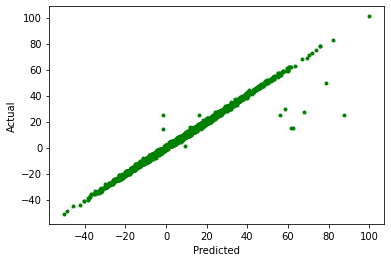

In [26]:
# Testing and plotting the actual vs predicted Marging of Victory
import matplotlib.pyplot as plt

plt.plot(Y_predict,Y_test,'g.')
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [27]:
filename='lr_model.sav'
joblib.dump(lr,filename)

['lr_model.sav']

pbp = dd.read_csv('gcs://sportsdata641/Datasets/mbb_pbp_sr*', dtype={'player_full_name': 'object',
       'player_id': 'object',
       'rebound_type': 'object',
       'shot_subtype': 'object',
       'shot_type': 'object',
       'team_alias': 'object',
       'team_conf_alias': 'object',
       'team_conf_name': 'object',
       'team_division_alias': 'object',
       'team_division_name': 'object',
       'team_id': 'object',
       'team_league_name': 'object',
       'team_market': 'object',
       'team_name': 'object',
       'turnover_type': 'object',
       'type': 'object',
       'game_no': 'object',
       'round': 'object',
       'tournament': 'object',
       'venue_zip': 'object',
       'tournament_type': 'object'},assume_missing=True)
pbpg = pbp[pbp['game_id'] == '5be9a30e-3582-465d-b19e-5388eddbacd5'].compute()

pbpg.sort_values(by = ['elapsed_time_sec'], inplace=True)

pos_time = []
for i in range(0,len(pbpg)-1):
    pos_time.append(pbpg.iloc[i+1]['elapsed_time_sec'] - pbpg.iloc[i]['elapsed_time_sec'])
pos_time.append(0)
pbpg['pos_time'] = pos_time

pbpg['home_team'] = (pbpg['home_id'] == pbpg['team_id'])

mins = pbpg.groupby(['home_team']).sum()['pos_time']

pd.DataFrame(pbpg.groupby(['home_team','event_type','type']).count())

x_test = pd.DataFrame()
x_test['minutes_int64_x'] = [mins[1]]
x_test['minutes_int64_y'] = [mins[0]]
x_test.join(pd.DataFrame(X.loc['5be9a30e-3582-465d-b19e-5388eddbacd5'][['attendance','lead_changes','times_tied','periods']]).transpose().reset_index())
#x_test

['minutes_int64_x', 'minutes_int64_y', 'attendance', 'lead_changes',
       'times_tied', 'periods', 'h_field_goals_att', 'h_field_goals_pct',
       'h_three_points_att', 'h_three_points_pct', 'h_two_points_att',
       'h_two_points_pct', 'h_blocked_att', 'h_free_throws_att',
       'h_free_throws_pct', 'h_offensive_rebounds', 'h_defensive_rebounds',
       'h_rebounds', 'h_assists', 'h_turnovers', 'h_steals', 'h_blocks',
       'h_assists_turnover_ratio', 'h_personal_fouls', 'h_ejections',
       'h_foulouts', 'h_team_turnovers', 'h_points_off_turnovers',
       'h_team_rebounds', 'h_flagrant_fouls', 'h_player_tech_fouls',
       'h_team_tech_fouls', 'h_coach_tech_fouls', 'a_field_goals_att',
       'a_field_goals_pct', 'a_three_points_att', 'a_three_points_pct',
       'a_two_points_att', 'a_two_points_pct', 'a_blocked_att',
       'a_free_throws_att', 'a_free_throws_pct', 'a_offensive_rebounds',
       'a_defensive_rebounds', 'a_rebounds', 'a_assists', 'a_turnovers',
       'a_steals', 'a_blocks', 'a_assists_turnover_ratio', 'a_personal_fouls',
       'a_ejections', 'a_foulouts', 'a_div', 'h_div', 'height_x', 'weight_x',
       'height_y', 'weight_y', 'a_team_turnovers', 'a_points_off_turnovers',
       'a_team_rebounds', 'a_flagrant_fouls', 'a_player_tech_fouls',
       'a_team_tech_fouls', 'a_coach_tech_fouls'],

pd.DataFrame(X.loc['5be9a30e-3582-465d-b19e-5388eddbacd5'][['attendance','lead_changes','times_tied','periods']]).transpose().reset_index()

# Reading the Play-By-Play dataset to compose the 1st half game statistics that we'll use to predict the MOV for the entire game for Testing

In [28]:
pbp_data = dd.read_csv('gcs://sportsdata641/Datasets/mbb_pbp_sr*', usecols =['period','game_id','team_id','home_id','away_id','event_type','event_description','elapsed_time_sec'],\
                      dtype={'team_id':object})

In [29]:
#Filtering out non-team events (e.g., official timeouts) and events from the second half
pbp_data2=pbp_data[(pbp_data["team_id"].notnull())&(pbp_data["period"]==1)]

In [30]:
pbp_data2.head()

,game_id,away_id,home_id,period,elapsed_time_sec,team_id,event_description,event_type
19141,063879c7-2bae-473f-aa3f-8a68f444bb73,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,532d3874-b4b3-4c5c-acc6-749a6db26c8f,1,957,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,Omar Richard turnover (traveling),turnover
19142,063879c7-2bae-473f-aa3f-8a68f444bb73,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,532d3874-b4b3-4c5c-acc6-749a6db26c8f,1,680,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,Omar Richard misses free throw 1 of 2,freethrowmiss
19143,063879c7-2bae-473f-aa3f-8a68f444bb73,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,532d3874-b4b3-4c5c-acc6-749a6db26c8f,1,716,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,Jay Mayernik misses two point layup,twopointmiss
19145,063879c7-2bae-473f-aa3f-8a68f444bb73,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,532d3874-b4b3-4c5c-acc6-749a6db26c8f,1,597,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,Jay Mayernik makes two point layup,twopointmade
19150,063879c7-2bae-473f-aa3f-8a68f444bb73,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,532d3874-b4b3-4c5c-acc6-749a6db26c8f,1,312,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,Javonte Byrd misses two point layup,twopointmiss


In [31]:
#pbp_data2.compute()
#1852059 rows is about 10k+ games, assuming about 170 first half plays per game

Note: event_type definitions can be found here: https://developer.sportradar.com/docs/basketball/NCAA_Mens_Basketball_v7#frequently-asked-questions

In [32]:
pbp_data2["2PA"]=(pbp_data2["event_type"].isin(["twopointmade","twopointmiss"]))
pbp_data2["2PM"]=(pbp_data2["event_type"]=="twopointmade")
pbp_data2["3PA"]=(pbp_data2["event_type"]=="threepointmade")|(pbp_data2["event_type"]=="threepointmiss")
pbp_data2["3PM"]=(pbp_data2["event_type"]=="threepointmade")
pbp_data2["FTA"]=(pbp_data2["event_type"]=="freethrowmade")|(pbp_data2["event_type"]=="freethrowmiss")
pbp_data2["FTM"]=(pbp_data2["event_type"]=="freethrowmade")
pbp_data2["TRB"]=(pbp_data2["event_type"]=="rebound")
pbp_data2["TO"]=(pbp_data2["event_type"]=="turnover")
pbp_data2["Foul"]=(pbp_data2["event_type"].isin(["flagrantone","flagranttwo","clearpathfoul","technicalfoul",\
                                                "minortechnicalfoul","personalfoul","defensivethreeseconds"]))
pbp_data2["Flagrant"]=(pbp_data2["event_type"].isin(["flagrantone","flagranttwo"]))
pbp_data2["Ejection"]=(pbp_data2["event_type"]=="ejection")


In [33]:
#pbp_data2.compute()

In [34]:
def checkast(row):
    if row["event_type"] in ["twopointmade","threepointmade"]:
        return "assist" in row["event_description"]
    else:
        return False


pbp_data2["AST"] =pbp_data2.apply(checkast,axis=1)

c:\users\shrey\appdata\local\programs\python\python38-32\lib\site-packages\dask\dataframe\core.py:4681: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'bool'))

  warnings.warn(meta_warning(meta))


In [35]:
def checkstl(row):
    if row["event_type"] == "turnover":
        return "steal" in row["event_description"]
    else:
        return False
    
pbp_data2["STLA"] =pbp_data2.apply(checkstl,axis=1)

def checkblk(row):
    if row["event_type"] in ["twopointmiss","threepointmiss"]:
        return "block" in row["event_description"]
    else:
        return False
pbp_data2["BLKA"] = pbp_data2.apply(checkblk,axis=1)


In [36]:
pbp_data2.head()

,game_id,away_id,home_id,period,elapsed_time_sec,team_id,event_description,event_type,2PA,2PM,3PA,3PM,FTA,FTM,TRB,TO,Foul,Flagrant,Ejection,AST,STLA,BLKA
19141,063879c7-2bae-473f-aa3f-8a68f444bb73,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,532d3874-b4b3-4c5c-acc6-749a6db26c8f,1,957,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,Omar Richard turnover (traveling),turnover,False,False,False,False,False,False,False,True,False,False,False,False,False,False
19142,063879c7-2bae-473f-aa3f-8a68f444bb73,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,532d3874-b4b3-4c5c-acc6-749a6db26c8f,1,680,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,Omar Richard misses free throw 1 of 2,freethrowmiss,False,False,False,False,True,False,False,False,False,False,False,False,False,False
19143,063879c7-2bae-473f-aa3f-8a68f444bb73,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,532d3874-b4b3-4c5c-acc6-749a6db26c8f,1,716,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,Jay Mayernik misses two point layup,twopointmiss,True,False,False,False,False,False,False,False,False,False,False,False,False,False
19145,063879c7-2bae-473f-aa3f-8a68f444bb73,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,532d3874-b4b3-4c5c-acc6-749a6db26c8f,1,597,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,Jay Mayernik makes two point layup,twopointmade,True,True,False,False,False,False,False,False,False,False,False,False,False,False
19150,063879c7-2bae-473f-aa3f-8a68f444bb73,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,532d3874-b4b3-4c5c-acc6-749a6db26c8f,1,312,9c7f3b90-ec9f-4a30-9ade-e0bcb8c8835e,Javonte Byrd misses two point layup,twopointmiss,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [37]:
pbp_data2[(pbp_data2["BLKA"])].head()

,game_id,away_id,home_id,period,elapsed_time_sec,team_id,event_description,event_type,2PA,2PM,3PA,3PM,FTA,FTM,TRB,TO,Foul,Flagrant,Ejection,AST,STLA,BLKA
19956,054771c4-3908-4486-b46a-104d50135101,c10544de-e3bd-4776-ba2e-83df8c017fd1,4383eb6a-7fd8-4ff2-94c5-43c933121e88,1,374,4383eb6a-7fd8-4ff2-94c5-43c933121e88,Jarrod Uthoff blocks JayVaughn Pinkston's two ...,twopointmiss,True,False,False,False,False,False,False,False,False,False,False,False,False,True
20067,5be9a30e-3582-465d-b19e-5388eddbacd5,0d8a328f-20ce-410b-bed1-15fc01308aaf,3a000455-de7c-4ca8-880e-abdce7f21da9,1,1024,0d8a328f-20ce-410b-bed1-15fc01308aaf,D.J. Haley blocks Myles Davis's two point shot,twopointmiss,True,False,False,False,False,False,False,False,False,False,False,False,False,True
20126,63d257d7-4865-49d1-afd1-fd4ca560bbd5,c10544de-e3bd-4776-ba2e-83df8c017fd1,06d15d35-4955-4fdd-83d9-32d24dbd795b,1,280,06d15d35-4955-4fdd-83d9-32d24dbd795b,Aaron White blocks Cedrick Lang's two point shot,twopointmiss,True,False,False,False,False,False,False,False,False,False,False,False,False,True
20137,679a305f-2359-4e0f-97ca-3d886ca3d1c3,b827dbdf-230f-4916-9703-3bb9004e26eb,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,1,743,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,Robert Hubbs III blocks Devin Thomas's two poi...,twopointmiss,True,False,False,False,False,False,False,False,False,False,False,False,False,True
20178,7bee62f8-1a9f-4ab9-896c-9200ef45eea8,06d15d35-4955-4fdd-83d9-32d24dbd795b,fae4855b-1b64-4b40-a632-9ed345e1e952,1,7,fae4855b-1b64-4b40-a632-9ed345e1e952,John Bohannon blocks Tarik Black's two point shot,twopointmiss,True,False,False,False,False,False,False,False,False,False,False,False,False,True


In [38]:
pbp_data3 = pbp_data2.groupby(["game_id","team_id"]).agg({'2PA':'sum','2PM':'sum','3PA':'sum','3PM':'sum','FTA':'sum',\
                                                         'FTM':'sum','TRB':'sum','TO':'sum','Foul':'sum','Flagrant':'sum',\
                                                         'Ejection':'sum','AST':'sum','STLA':'sum','BLKA':'sum'})

In [39]:
%%time
agg_data = pbp_data3.compute()

Wall time: 2min 43s


In [40]:
#agg_data["PTS"] = 2*agg_data["2PM"]+3*agg_data["3PM"]+agg_data["FTM"]
display(agg_data)

2PA  \
game_id                              team_id                                     
000872e5-f02a-4b64-ac73-b6b1a7ad10ec 4f4b0771-994c-4126-822d-7525aaa00f65   17   
                                     912f8837-1d81-4ef9-a576-a21f271d4c64   15   
000918c3-b8bf-472a-9a12-94a1984700eb 1551b3a0-6d10-4ffa-8dfa-73b56f004553   25   
                                     b795ddbc-baab-4499-8803-52e8608520ab   19   
000b3698-3ce9-44bd-954b-65703a2c6ef1 4f4b0771-994c-4126-822d-7525aaa00f65   22   
...                                                                        ...   
daec9de3-4a8a-4125-8978-a38e1fd18264 dfe0d93f-94a5-47fb-b7aa-f74786e09acb   22   
db626521-110e-443b-83a8-00ae1aaa5a28 61a3908a-7492-4b6f-809e-12c61976bb0a   18   
                                     d203f38a-a166-4258-bca2-e161b591ecfb   18   
f1063e80-23c7-486b-9a5e-faa52beb2d83 4383eb6a-7fd8-4ff2-94c5-43c933121e88   18   
                                     bdc2561d-f603-4fab-a262-f1d2af462277   15   

                                                                           2PM  \
game_id                              team_id                                     
000872e5-f02a-4b64-ac73-b6b1a7ad10ec 4f4b0771-994c-4126-822d-7525aaa00f65    7   
                                     912f8837-1d81-4ef9-a576-a21f271d4c64    3   
000918c3-b8bf-472a-9a12-94a1984700eb 1551b3a0-6d10-4ffa-8dfa-73b56f004553   11   
                                     b795ddbc-baab-4499-8803-52e8608520ab    9   
000b3698-3ce9-44bd-954b-65703a2c6ef1 4f4b0771-994c-4126-822d-7525aaa00f65    8   
...                                                                        ...   
daec9de3-4a8a-4125-8978-a38e1fd18264 dfe0d93f-94a5-47fb-b7aa-f74786e09acb    5   
db626521-110e-443b-83a8-00ae1aaa5a28 61a3908a-7492-4b6f-809e-12c61976bb0a   11   
                                     d203f38a-a166-4258-bca2-e161b591ecfb    8   
f1063e80-23c7-486b-9a5e-faa52beb2d83 4383eb6a-7fd8-4ff2-94c5-43c933121e88   10   
                                     bdc2561d-f603-4fab-a262-f1d2af462277    9   

                                                                           3PA  \
game_id                              team_id                                     
000872e5-f02a-4b64-ac73-b6b1a7ad10ec 4f4b0771-994c-4126-822d-7525aaa00f65    6   
                                     912f8837-1d81-4ef9-a576-a21f271d4c64   16   
000918c3-b8bf-472a-9a12-94a1984700eb 1551b3a0-6d10-4ffa-8dfa-73b56f004553    4   
                                     b795ddbc-baab-4499-8803-52e8608520ab    8   
000b3698-3ce9-44bd-954b-65703a2c6ef1 4f4b0771-994c-4126-822d-7525aaa00f65    9   
...                                                                        ...   
daec9de3-4a8a-4125-8978-a38e1fd18264 dfe0d93f-94a5-47fb-b7aa-f74786e09acb   10   
db626521-110e-443b-83a8-00ae1aaa5a28 61a3908a-7492-4b6f-809e-12c61976bb0a    9   
                                     d203f38a-a166-4258-bca2-e161b591ecfb    9   
f1063e80-23c7-486b-9a5e-faa52beb2d83 4383eb6a-7fd8-4ff2-94c5-43c933121e88   13   
                                     bdc2561d-f603-4fab-a262-f1d2af462277   13   

                                                                           3PM  \
game_id                              team_id                                     
000872e5-f02a-4b64-ac73-b6b1a7ad10ec 4f4b0771-994c-4126-822d-7525aaa00f65    1   
                                     912f8837-1d81-4ef9-a576-a21f271d4c64    7   
000918c3-b8bf-472a-9a12-94a1984700eb 1551b3a0-6d10-4ffa-8dfa-73b56f004553    3   
                                     b795ddbc-baab-4499-8803-52e8608520ab    2   
000b3698-3ce9-44bd-954b-65703a2c6ef1 4f4b0771-994c-4126-822d-7525aaa00f65    1   
...                                                                        ...   
daec9de3-4a8a-4125-8978-a38e1fd18264 dfe0d93f-94a5-47fb-b7aa-f74786e09acb    3   
db626521-110e-443b-83a8-00ae1aaa5a28 61a3908a-7492-4b6f-809e-12c61976bb0a    4   
                                     d203f38a-a166-425

# Merging aggregated first half data to game data:
Plan: 
1) Compute pandas dataframe g_data
2) Merge agg_data to g_data using game_id and team_id to game_id and h_id, prefix with h
3) Merge agg_data to g_data using game_id and team_id to game_id and a_id, prefix with a

In [41]:
g_data = games_data.compute()
display(g_data)



,game_id,season,status,coverage,neutral_site,scheduled_date,gametime,conference_game,tournament,tournament_type,tournament_round,tournament_game_no,attendance,lead_changes,times_tied,periods,possession_arrow,venue_id,venue_city,venue_state,venue_address,venue_zip,venue_country,venue_name,venue_capacity,h_name,h_market,h_id,h_alias,h_league_id,h_league_name,h_league_alias,h_conf_id,h_conf_name,h_conf_alias,h_division_id,h_division_name,h_division_alias,h_logo_large,h_logo_medium,h_logo_small,h_points_game,h_rank,h_minutes,h_field_goals_made,h_field_goals_att,h_field_goals_pct,h_three_points_made,h_three_points_att,h_three_points_pct,h_two_points_made,h_two_points_att,h_two_points_pct,h_blocked_att,h_free_throws_made,h_free_throws_att,h_free_throws_pct,h_offensive_rebounds,h_defensive_rebounds,h_rebounds,h_assists,h_turnovers,h_steals,h_blocks,h_assists_turnover_ratio,h_personal_fouls,h_ejections,h_foulouts,h_points,h_fast_break_pts,h_second_chance_pts,h_team_turnovers,h_points_off_turnovers,h_team_rebounds,h_flagrant_fouls,h_player_tech_fouls,h_team_tech_fouls,h_coach_tech_fouls,a_name,a_market,a_id,a_alias,a_league_id,a_league_name,a_league_alias,a_conf_id,a_conf_name,a_conf_alias,a_division_id,a_division_name,a_division_alias,a_logo_large,a_logo_medium,a_logo_small,a_points_game,a_rank,a_minutes,a_field_goals_made,a_field_goals_att,a_field_goals_pct,a_three_points_made,a_three_points_att,a_three_points_pct,a_two_points_made,a_two_points_att,a_two_points_pct,a_blocked_att,a_free_throws_made,a_free_throws_att,a_free_throws_pct,a_offensive_rebounds,a_defensive_rebounds,a_rebounds,a_assists,a_turnovers,a_steals,a_blocks,a_assists_turnover_ratio,a_personal_fouls,a_ejections,a_foulouts,a_points,a_fast_break_pts,a_second_chance_pts,a_team_turnovers,a_points_off_turnovers,a_team_rebounds,a_flagrant_fouls,a_player_tech_fouls,a_team_tech_fouls,a_coach_tech_fouls,created,MOV
0,b4451a02-26c5-4005-9ac8-b06c1f71e661,2015.0,closed,full,NaN,2015-11-24,2015-11-24 21:30:00 UTC,NaN,NaN,NaN,NaN,NaN,2277.0,3.0,2.0,2.0,68a3227f-677f-43b0-9a3a-cad79d0df9e2,c69e13a7-4637-4b0e-9ca8-043ac5738a9d,Maui,HI,1840 Honoapiilani Hwy,96761,USA,Lahaina Civic Center,2400.0,Silverswords,Chaminade University,ef13a371-76ed-409c-9aa6-35135183e170,CHA,cd4268ee-07aa-4c4d-a435-ec44ad2c76cb,NCAA MEN,NCAAM,ff8025b4-2752-413b-a6fe-4a5c36c47bab,Pacific West Conference,PACWEST-D2,9c6f6fe5-c9a1-4260-8d87-f9866ca271ba,NCAA Division II,D2,NaN,NaN,NaN,73.0,0.0,3:20:00,26.0,61.0,42.6,10.0,19.0,52.6,16.0,42.0,0.381,7.0,11.0,16.0,68.8,6.0,26.0,32.0,17.0,22.0,6.0,2.0,0.77,25.0,0.0,NaN,73.0,14.0,3.0,0.0,19.0,2.0,0.0,0.0,0.0,0.0,Rebels,UNLV,68a3227f-677f-43b0-9a3a-cad79d0df9e2,UNLV,cd4268ee-07aa-4c4d-a435-ec44ad2c76cb,NCAA MEN,NCAAM,93a776e4-d390-48e1-95bb-74945457366a,Mountain West,MWC,c5a8d640-5093-4044-851d-2c562e929994,NCAA Division I,D1,https://www.ncaa.com/sites/default/files/image...,https://www.ncaa.com/sites/default/files/image...,https://www.ncaa.com/sites/default/files/image...,93.0,0.0,3:20:00,37.0,76.0,48.7,4.0,16.0,25.0,33.0,60.0,0.550,2.0,15.0,30.0,50.0,16.0,29.0,45.0,15.0,10.0,16.0,7.0,1.50,17.0,0.0,NaN,93.0,36.0,17.0,0.0,31.0,5.0,0.0,0.0,0.0,0.0,2018-02-20 15:48:58 UTC,-20.0
1,b2f579ca-9eff-4b2b-a747-81169399c2e8,2015.0,closed,full,NaN,2015-11-24,2015-11-24 02:00:00 UTC,NaN,NaN,NaN,NaN,NaN,2277.0,1.0,0.0,2.0,fae4855b-1b64-4b40-a632-9ed345e1e952,c69e13a7-4637-4b0e-9ca8-043ac5738a9d,Maui,HI,1840 Honoapiilani Hwy,96761,USA,Lahaina Civic Center,2400.0,Silverswords,Chaminade University,ef13a371-76ed-409c-9aa6-35135183e170,CHA,cd4268ee-07aa-4c4d-a435-ec44ad2c76cb,NCAA MEN,NCAAM,ff8025b4-2752-413b-a6fe-4a5c36c47bab,Pacific West Conference,PACWEST-D2,9c6f6fe5-c9a1-4260-8d87-f9866ca271ba,NCAA Division II,D2,NaN,NaN,NaN,72.0,0.0,3:20:00,24.0,69.0,34.8,8.0,33.0,24.2,16.0,36.0,0.444,7.0,16.0,21.0,76.2,9.0,13.0,22.0,10.0,14.0,7.0,1.0,0.71,21.0,0.0,NaN,72.0,6.0,13.0,0.0,9.0,4.0,0.0,0.0,0.0,0.0,Jayhawks,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,KU,cd4268ee-07aa-4c4d-a435-ec44ad2c

In [42]:
# Margin of Victory column
games_data['MOV'] = games_data['h_points_game']-games_data['a_points_game']
print("--------")
display(games_data['MOV'])
print("--------")
display(games_data.compute()['MOV'])

--------


Dask Series Structure:
npartitions=2
0        float64
7452         ...
14998        ...
Name: MOV, dtype: float64
Dask Name: getitem, 22 tasks

--------


0       -20.0
1       -51.0
2        -7.0
3        13.0
4         5.0
         ... 
14801    16.0
14802    -8.0
14803   -14.0
14804     2.0
14805    14.0
Name: MOV, Length: 25796, dtype: float64

In [43]:
feature_subset = ['game_id','h_id','a_id','season','conference_game','tournament','tournament_type',\
                 'tournament_round','tournament_game_no','attendance','venue_id','venue_city','venue_state','lead_changes','times_tied','periods',\
                 'venue_address','venue_zip','venue_capacity','MOV',\
                 'h_market','h_conf_id','h_conf_name','h_division_alias','h_points_game',\
                 'a_market','a_conf_id','a_conf_name','a_division_alias','a_points_game']

In [44]:
g_data = games_data[feature_subset].compute()

In [45]:
g_data2 = g_data.merge(agg_data.add_prefix('h_'),how='inner',left_on=['game_id','h_id'],right_on=['game_id','team_id'])
display(g_data2)

,game_id,h_id,a_id,season,conference_game,tournament,tournament_type,tournament_round,tournament_game_no,attendance,venue_id,venue_city,venue_state,lead_changes,times_tied,periods,venue_address,venue_zip,venue_capacity,MOV,h_market,h_conf_id,h_conf_name,h_division_alias,h_points_game,a_market,a_conf_id,a_conf_name,a_division_alias,a_points_game,h_2PA,h_2PM,h_3PA,h_3PM,h_FTA,h_FTM,h_TRB,h_TO,h_Foul,h_Flagrant,h_Ejection,h_AST,h_STLA,h_BLKA
0,b4451a02-26c5-4005-9ac8-b06c1f71e661,ef13a371-76ed-409c-9aa6-35135183e170,68a3227f-677f-43b0-9a3a-cad79d0df9e2,2015.0,NaN,NaN,NaN,NaN,NaN,2277.0,c69e13a7-4637-4b0e-9ca8-043ac5738a9d,Maui,HI,3.0,2.0,2.0,1840 Honoapiilani Hwy,96761,2400.0,-20.0,Chaminade University,ff8025b4-2752-413b-a6fe-4a5c36c47bab,Pacific West Conference,D2,73.0,UNLV,93a776e4-d390-48e1-95bb-74945457366a,Mountain West,D1,93.0,26,11,7,4,6,3,26,16,9,0,0,8,12,5
1,b2f579ca-9eff-4b2b-a747-81169399c2e8,ef13a371-76ed-409c-9aa6-35135183e170,fae4855b-1b64-4b40-a632-9ed345e1e952,2015.0,NaN,NaN,NaN,NaN,NaN,2277.0,c69e13a7-4637-4b0e-9ca8-043ac5738a9d,Maui,HI,1.0,0.0,2.0,1840 Honoapiilani Hwy,96761,2400.0,-51.0,Chaminade University,ff8025b4-2752-413b-a6fe-4a5c36c47bab,Pacific West Conference,D2,72.0,Kansas,2853cf4d-6d62-4ec6-8e2c-d69f7a01a557,Big 12,D1,123.0,14,5,18,4,13,11,20,10,8,0,0,3,7,4
2,571be71c-a5bf-446e-bf21-30eb6c54ac5e,ef13a371-76ed-409c-9aa6-35135183e170,c1f4aae1-aa16-4095-aeab-10e5c2a1236a,2015.0,NaN,NaN,NaN,NaN,NaN,2277.0,c69e13a7-4637-4b0e-9ca8-043ac5738a9d,Maui,HI,2.0,0.0,2.0,1840 Honoapiilani Hwy,96761,2400.0,-7.0,Chaminade University,ff8025b4-2752-413b-a6fe-4a5c36c47bab,Pacific West Conference,D2,93.0,St. John's,d07bc93e-c84c-44a9-a99d-c213bd0014d6,Big East,D1,100.0,14,9,15,7,7,3,11,11,0,0,0,9,7,2
3,d6617923-0b23-49e4-af9b-9e4d0243e45c,532d3874-b4b3-4c5c-acc6-749a6db26c8f,c009914b-3303-4dee-b915-978aa48a31d0,2015.0,NaN,NaN,NaN,NaN,NaN,5336.0,1d1f74a2-7b35-56f0-8cbd-552c51cb2c14,Portland,OR,9.0,1.0,2.0,1 Center Court,97227,19441.0,13.0,Oregon State,04d5255d-b2dc-43df-9fa8-d296b0f8ccd7,Pacific 12,D1,82.0,Cal State Fullerton,5f56da49-5d81-43c3-8652-8b8da40c907f,Big West,D1,69.0,19,10,14,6,9,6,24,5,3,0,0,8,1,0
4,ffb463a4-dd3c-4ed9-b503-311b95ef0295,532d3874-b4b3-4c5c-acc6-749a6db26c8f,2959bd24-7007-41ae-a3a3-abdf26888cfc,2015.0,NaN,NaN,NaN,NaN,NaN,5336.0,1d1f74a2-7b35-56f0-8cbd-552c51cb2c14,Portland,OR,1.0,3.0,2.0,1 Center Court,97227,19441.0,5.0,Oregon State,04d5255d-b2dc-43df-9fa8-d296b0f8ccd7,Pacific 12,D1,76.0,Tulsa,3b6a48d8-1f9c-484f-8ed0-ef0a540a0efe,American Athletic,D1,71.0,19,6,6,2,12,10,20,12,3,0,0,5,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11158,9dfe8c82-8d85-42f7-b88d-5a3e2849c74c,bdb7d7a4-45f8-4bf3-ab85-15488c451494,9b166a3f-e64b-4825-bb6b-92c6f0418263,2016.0,False,NaN,NaN,NaN,NaN,4518.0,7b49816c-cac2-40d5-97bc-7c8c0935039d,Las Vegas,NV,11.0,9.0,2.0,4500 W. Tropicana Ave,89103,7471.0,4.0,Butler,d07bc93e-c84c-44a9-a99d-c213bd0014d6,Big East,D1,69.0,Arizona,04d5255d-b2dc-43df-9fa8-d296b0f8ccd7,Pacific 12,D1,65.0,16,6,10,5,11,9,13,7,8,0,0,6,3,1
11159,79e583e6-fffe-460e-821b-2157affad34f,d52c3640-069c-4554-982e-e6537c8044f1,0d8a328f-20ce-410b-bed1-15fc01308aaf,2017.0,False,NaN,NaN,NaN,NaN,2356.0,7b49816c-cac2-40d5-97bc-7c8c0935039d,Las Vegas,NV,0.0,2.0,2.0,4500 W Tropicana Ave,89103,9500.0,-19.0,George Washington,db136c00-f45b-4af6-bc7d-ffff216f2e5d,Atlantic 10,D1,64.0,Xavier,d07bc93e-c84c-44a9-a99d-c213bd0014d6,Big East,D1,83.0,15,5,13,7,9,5,16,10,3,0,0,5,6,0
11160,346a418b-995d-4a81-9d02-e567d6265878,fea46ac5-6dad-43cd-a770-75554dbcc118,7cdfcf92-7fe7-46f1-9b66-6912114182e6,2017.0,False,NaN,NaN,NaN,NaN,2489.0,7b49816c-cac2-40d5-97bc-7c8c0935039d,Las Vegas,NV,6.0,5.0,2.0,4500 W Tropicana Ave,89103,9500.0,-10.0,Duquesne,db136c00-f45b-4af6-bc7d-ffff216f2e5d,Atlantic 10,D1,64.0,Southern Illinois,1d9219c1-696c-42a2-b1be-e8b438795521,Missouri Valley,D1,74.0,19,9,7,1,11,9,22,10,

In [46]:
g_data2.columns

Index(['game_id', 'h_id', 'a_id', 'season', 'conference_game', 'tournament',
       'tournament_type', 'tournament_round', 'tournament_game_no',
       'attendance', 'venue_id', 'venue_city', 'venue_state', 'lead_changes',
       'times_tied', 'periods', 'venue_address', 'venue_zip', 'venue_capacity',
       'MOV', 'h_market', 'h_conf_id', 'h_conf_name', 'h_division_alias',
       'h_points_game', 'a_market', 'a_conf_id', 'a_conf_name',
       'a_division_alias', 'a_points_game', 'h_2PA', 'h_2PM', 'h_3PA', 'h_3PM',
       'h_FTA', 'h_FTM', 'h_TRB', 'h_TO', 'h_Foul', 'h_Flagrant', 'h_Ejection',
       'h_AST', 'h_STLA', 'h_BLKA'],
      dtype='object')

In [47]:
g_data3 = g_data2.merge(agg_data.add_prefix('a_'),how='inner',left_on=['game_id','a_id'],right_on=['game_id','team_id'])

In [48]:
display(g_data3)

,game_id,h_id,a_id,season,conference_game,tournament,tournament_type,tournament_round,tournament_game_no,attendance,venue_id,venue_city,venue_state,lead_changes,times_tied,periods,venue_address,venue_zip,venue_capacity,MOV,h_market,h_conf_id,h_conf_name,h_division_alias,h_points_game,a_market,a_conf_id,a_conf_name,a_division_alias,a_points_game,h_2PA,h_2PM,h_3PA,h_3PM,h_FTA,h_FTM,h_TRB,h_TO,h_Foul,h_Flagrant,h_Ejection,h_AST,h_STLA,h_BLKA,a_2PA,a_2PM,a_3PA,a_3PM,a_FTA,a_FTM,a_TRB,a_TO,a_Foul,a_Flagrant,a_Ejection,a_AST,a_STLA,a_BLKA
0,b4451a02-26c5-4005-9ac8-b06c1f71e661,ef13a371-76ed-409c-9aa6-35135183e170,68a3227f-677f-43b0-9a3a-cad79d0df9e2,2015.0,NaN,NaN,NaN,NaN,NaN,2277.0,c69e13a7-4637-4b0e-9ca8-043ac5738a9d,Maui,HI,3.0,2.0,2.0,1840 Honoapiilani Hwy,96761,2400.0,-20.0,Chaminade University,ff8025b4-2752-413b-a6fe-4a5c36c47bab,Pacific West Conference,D2,73.0,UNLV,93a776e4-d390-48e1-95bb-74945457366a,Mountain West,D1,93.0,26,11,7,4,6,3,26,16,9,0,0,8,12,5,19,9,11,2,17,9,17,15,5,0,0,6,12,2
1,b2f579ca-9eff-4b2b-a747-81169399c2e8,ef13a371-76ed-409c-9aa6-35135183e170,fae4855b-1b64-4b40-a632-9ed345e1e952,2015.0,NaN,NaN,NaN,NaN,NaN,2277.0,c69e13a7-4637-4b0e-9ca8-043ac5738a9d,Maui,HI,1.0,0.0,2.0,1840 Honoapiilani Hwy,96761,2400.0,-51.0,Chaminade University,ff8025b4-2752-413b-a6fe-4a5c36c47bab,Pacific West Conference,D2,72.0,Kansas,2853cf4d-6d62-4ec6-8e2c-d69f7a01a557,Big 12,D1,123.0,14,5,18,4,13,11,20,10,8,0,0,3,7,4,21,13,16,7,8,6,24,11,9,0,0,14,7,0
2,571be71c-a5bf-446e-bf21-30eb6c54ac5e,ef13a371-76ed-409c-9aa6-35135183e170,c1f4aae1-aa16-4095-aeab-10e5c2a1236a,2015.0,NaN,NaN,NaN,NaN,NaN,2277.0,c69e13a7-4637-4b0e-9ca8-043ac5738a9d,Maui,HI,2.0,0.0,2.0,1840 Honoapiilani Hwy,96761,2400.0,-7.0,Chaminade University,ff8025b4-2752-413b-a6fe-4a5c36c47bab,Pacific West Conference,D2,93.0,St. John's,d07bc93e-c84c-44a9-a99d-c213bd0014d6,Big East,D1,100.0,14,9,15,7,7,3,11,11,0,0,0,9,7,2,19,13,12,9,6,6,13,10,3,0,0,10,7,0
3,d6617923-0b23-49e4-af9b-9e4d0243e45c,532d3874-b4b3-4c5c-acc6-749a6db26c8f,c009914b-3303-4dee-b915-978aa48a31d0,2015.0,NaN,NaN,NaN,NaN,NaN,5336.0,1d1f74a2-7b35-56f0-8cbd-552c51cb2c14,Portland,OR,9.0,1.0,2.0,1 Center Court,97227,19441.0,13.0,Oregon State,04d5255d-b2dc-43df-9fa8-d296b0f8ccd7,Pacific 12,D1,82.0,Cal State Fullerton,5f56da49-5d81-43c3-8652-8b8da40c907f,Big West,D1,69.0,19,10,14,6,9,6,24,5,3,0,0,8,1,0,12,4,16,6,13,6,18,4,5,0,0,5,1,1
4,ffb463a4-dd3c-4ed9-b503-311b95ef0295,532d3874-b4b3-4c5c-acc6-749a6db26c8f,2959bd24-7007-41ae-a3a3-abdf26888cfc,2015.0,NaN,NaN,NaN,NaN,NaN,5336.0,1d1f74a2-7b35-56f0-8cbd-552c51cb2c14,Portland,OR,1.0,3.0,2.0,1 Center Court,97227,19441.0,5.0,Oregon State,04d5255d-b2dc-43df-9fa8-d296b0f8ccd7,Pacific 12,D1,76.0,Tulsa,3b6a48d8-1f9c-484f-8ed0-ef0a540a0efe,American Athletic,D1,71.0,19,6,6,2,12,10,20,12,3,0,0,5,7,2,22,9,7,2,15,10,19,12,6,0,0,6,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11158,9dfe8c82-8d85-42f7-b88d-5a3e2849c74c,bdb7d7a4-45f8-4bf3-ab85-15488c451494,9b166a3f-e64b-4825-bb6b-92c6f0418263,2016.0,False,NaN,NaN,NaN,NaN,4518.0,7b49816c-cac2-40d5-97bc-7c8c0935039d,Las Vegas,NV,11.0,9.0,2.0,4500 W. Tropicana Ave,89103,7471.0,4.0,Butler,d07bc93e-c84c-44a9-a99d-c213bd0014d6,Big East,D1,69.0,Arizona,04d5255d-b2dc-43df-9fa8-d296b0f8ccd7,Pacific 12,D1,65.0,16,6,10,5,11,9,13,7,8,0,0,6,3,1,19,9,8,3,11,7,20,10,6,0,0,7,3,2
11159,79e583e6-fffe-460e-821b-2157affad34f,d52c3640-069c-4554-982e-e6537c8044f1,0d8a328f-20ce-410b-bed1-15fc01308aaf,2017.0,False,NaN,NaN,NaN,NaN,2356.0,7b49816c-cac2-40d5-97bc-7c8c0935039d,Las Vegas,NV,0.0,2.0,2.0,4500 W Tropicana Ave,89103,9500.0,-19.0,George Washington,db136c00-f45b-4af6-bc7d-ffff216f2e5d,Atlantic 10,D1,64.0,Xavier,d07bc93e-c84c-44a9-a99d-c213bd0014d6,Big East,D1,83.0,15,5,13,7,9,5,16,10,3,0,0,5,6,0,26,14,7,4,5,3,19,10,3,0,0,8,6,4
11160,346a418b-995d-4a81-9d02-e567d62

In [49]:
type(g_data3)

pandas.core.frame.DataFrame

In [50]:
g_data4 = g_data3.set_index(['game_id'],verify_integrity=True)
display(g_data4)

,h_id,a_id,season,conference_game,tournament,tournament_type,tournament_round,tournament_game_no,attendance,venue_id,venue_city,venue_state,lead_changes,times_tied,periods,venue_address,venue_zip,venue_capacity,MOV,h_market,h_conf_id,h_conf_name,h_division_alias,h_points_game,a_market,a_conf_id,a_conf_name,a_division_alias,a_points_game,h_2PA,h_2PM,h_3PA,h_3PM,h_FTA,h_FTM,h_TRB,h_TO,h_Foul,h_Flagrant,h_Ejection,h_AST,h_STLA,h_BLKA,a_2PA,a_2PM,a_3PA,a_3PM,a_FTA,a_FTM,a_TRB,a_TO,a_Foul,a_Flagrant,a_Ejection,a_AST,a_STLA,a_BLKA
game_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
b4451a02-26c5-4005-9ac8-b06c1f71e661,ef13a371-76ed-409c-9aa6-35135183e170,68a3227f-677f-43b0-9a3a-cad79d0df9e2,2015.0,NaN,NaN,NaN,NaN,NaN,2277.0,c69e13a7-4637-4b0e-9ca8-043ac5738a9d,Maui,HI,3.0,2.0,2.0,1840 Honoapiilani Hwy,96761,2400.0,-20.0,Chaminade University,ff8025b4-2752-413b-a6fe-4a5c36c47bab,Pacific West Conference,D2,73.0,UNLV,93a776e4-d390-48e1-95bb-74945457366a,Mountain West,D1,93.0,26,11,7,4,6,3,26,16,9,0,0,8,12,5,19,9,11,2,17,9,17,15,5,0,0,6,12,2
b2f579ca-9eff-4b2b-a747-81169399c2e8,ef13a371-76ed-409c-9aa6-35135183e170,fae4855b-1b64-4b40-a632-9ed345e1e952,2015.0,NaN,NaN,NaN,NaN,NaN,2277.0,c69e13a7-4637-4b0e-9ca8-043ac5738a9d,Maui,HI,1.0,0.0,2.0,1840 Honoapiilani Hwy,96761,2400.0,-51.0,Chaminade University,ff8025b4-2752-413b-a6fe-4a5c36c47bab,Pacific West Conference,D2,72.0,Kansas,2853cf4d-6d62-4ec6-8e2c-d69f7a01a557,Big 12,D1,123.0,14,5,18,4,13,11,20,10,8,0,0,3,7,4,21,13,16,7,8,6,24,11,9,0,0,14,7,0
571be71c-a5bf-446e-bf21-30eb6c54ac5e,ef13a371-76ed-409c-9aa6-35135183e170,c1f4aae1-aa16-4095-aeab-10e5c2a1236a,2015.0,NaN,NaN,NaN,NaN,NaN,2277.0,c69e13a7-4637-4b0e-9ca8-043ac5738a9d,Maui,HI,2.0,0.0,2.0,1840 Honoapiilani Hwy,96761,2400.0,-7.0,Chaminade University,ff8025b4-2752-413b-a6fe-4a5c36c47bab,Pacific West Conference,D2,93.0,St. John's,d07bc93e-c84c-44a9-a99d-c213bd0014d6,Big East,D1,100.0,14,9,15,7,7,3,11,11,0,0,0,9,7,2,19,13,12,9,6,6,13,10,3,0,0,10,7,0
d6617923-0b23-49e4-af9b-9e4d0243e45c,532d3874-b4b3-4c5c-acc6-749a6db26c8f,c009914b-3303-4dee-b915-978aa48a31d0,2015.0,NaN,NaN,NaN,NaN,NaN,5336.0,1d1f74a2-7b35-56f0-8cbd-552c51cb2c14,Portland,OR,9.0,1.0,2.0,1 Center Court,97227,19441.0,13.0,Oregon State,04d5255d-b2dc-43df-9fa8-d296b0f8ccd7,Pacific 12,D1,82.0,Cal State Fullerton,5f56da49-5d81-43c3-8652-8b8da40c907f,Big West,D1,69.0,19,10,14,6,9,6,24,5,3,0,0,8,1,0,12,4,16,6,13,6,18,4,5,0,0,5,1,1
ffb463a4-dd3c-4ed9-b503-311b95ef0295,532d3874-b4b3-4c5c-acc6-749a6db26c8f,2959bd24-7007-41ae-a3a3-abdf26888cfc,2015.0,NaN,NaN,NaN,NaN,NaN,5336.0,1d1f74a2-7b35-56f0-8cbd-552c51cb2c14,Portland,OR,1.0,3.0,2.0,1 Center Court,97227,19441.0,5.0,Oregon State,04d5255d-b2dc-43df-9fa8-d296b0f8ccd7,Pacific 12,D1,76.0,Tulsa,3b6a48d8-1f9c-484f-8ed0-ef0a540a0efe,American Athletic,D1,71.0,19,6,6,2,12,10,20,12,3,0,0,5,7,2,22,9,7,2,15,10,19,12,6,0,0,6,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9dfe8c82-8d85-42f7-b88d-5a3e2849c74c,bdb7d7a4-45f8-4bf3-ab85-15488c451494,9b166a3f-e64b-4825-bb6b-92c6f0418263,2016.0,False,NaN,NaN,NaN,NaN,4518.0,7b49816c-cac2-40d5-97bc-7c8c0935039d,Las Vegas,NV,11.0,9.0,2.0,4500 W. Tropicana Ave,89103,7471.0,4.0,Butler,d07bc93e-c84c-44a9-a99d-c213bd0014d6,Big East,D1,69.0,Arizona,04d5255d-b2dc-43df-9fa8-d296b0f8ccd7,Pacific 12,D1,65.0,16,6,10,5,11,9,13,7,8,0,0,6,3,1,19,9,8,3,11,7,20,10,6,0,0,7,3,2
79e583e6-fffe-460e-821b-2157affad34f,d52c3640-069c-4554-982e-e6537c8044f1,0d8a328f-20ce-410b-bed1-15fc01308aaf,2017.0,False,NaN,NaN,NaN,NaN,2356.0,7b49816c-cac2-40d5-97bc-7c8c0935039d,Las Vegas,NV,0.0,2.0,2.0,4500 W Tropicana Ave,89103,9500.0,-19.0,George Washington,db136c00-f45b-4af6-bc7d-ffff216f2e5d,Atlantic 10,D1,64.0,Xavier,d07bc93e-c84c-44a9-a99d-c213bd0014d6,Big East,D1,83.0,15,5,13,7,9,5,16,10,3,0,0,5,6,0,26,14,7,4,5,3,19,10,3,0,0,8,6,4
346a41

In [51]:
df = g_data4.loc[(g_data4['h_division_alias']=='D1')&(g_data4['a_division_alias']=='D1')]

Merging the 1st half data with Y_Test dataframe

In [52]:
tst_features = g_data4.columns
display(tst_features)
display(features)
g_data5 = g_data4.drop(columns=['h_id', 'a_id', 'season', 'conference_game', 'tournament',
       'tournament_type', 'tournament_round', 'tournament_game_no','venue_id', 'venue_city', 'venue_state','venue_address', 'venue_zip', 'venue_capacity',
       'MOV', 'h_market', 'h_conf_id', 'h_conf_name', 'h_division_alias',
       'h_points_game', 'a_market', 'a_conf_id', 'a_conf_name',
       'a_division_alias', 'a_points_game'])
g_data5

Index(['h_id', 'a_id', 'season', 'conference_game', 'tournament',
       'tournament_type', 'tournament_round', 'tournament_game_no',
       'attendance', 'venue_id', 'venue_city', 'venue_state', 'lead_changes',
       'times_tied', 'periods', 'venue_address', 'venue_zip', 'venue_capacity',
       'MOV', 'h_market', 'h_conf_id', 'h_conf_name', 'h_division_alias',
       'h_points_game', 'a_market', 'a_conf_id', 'a_conf_name',
       'a_division_alias', 'a_points_game', 'h_2PA', 'h_2PM', 'h_3PA', 'h_3PM',
       'h_FTA', 'h_FTM', 'h_TRB', 'h_TO', 'h_Foul', 'h_Flagrant', 'h_Ejection',
       'h_AST', 'h_STLA', 'h_BLKA', 'a_2PA', 'a_2PM', 'a_3PA', 'a_3PM',
       'a_FTA', 'a_FTM', 'a_TRB', 'a_TO', 'a_Foul', 'a_Flagrant', 'a_Ejection',
       'a_AST', 'a_STLA', 'a_BLKA'],
      dtype='object')

['attendance',
 'lead_changes',
 'times_tied',
 'periods',
 'h_three_points_made',
 'h_three_points_att',
 'h_two_points_made',
 'h_two_points_att',
 'h_free_throws_made',
 'h_free_throws_att',
 'h_personal_fouls',
 'h_rebounds',
 'h_assists',
 'h_turnovers',
 'h_steals',
 'h_blocks',
 'h_ejections',
 'h_flagrant_fouls',
 'a_three_points_made',
 'a_three_points_att',
 'a_two_points_made',
 'a_two_points_att',
 'a_free_throws_made',
 'a_free_throws_att',
 'a_personal_fouls',
 'a_rebounds',
 'a_assists',
 'a_turnovers',
 'a_steals',
 'a_blocks',
 'a_ejections',
 'a_flagrant_fouls',
 'a_div',
 'h_div',
 'height_h',
 'weight_h',
 'height_a',
 'weight_a']

,attendance,lead_changes,times_tied,periods,h_2PA,h_2PM,h_3PA,h_3PM,h_FTA,h_FTM,h_TRB,h_TO,h_Foul,h_Flagrant,h_Ejection,h_AST,h_STLA,h_BLKA,a_2PA,a_2PM,a_3PA,a_3PM,a_FTA,a_FTM,a_TRB,a_TO,a_Foul,a_Flagrant,a_Ejection,a_AST,a_STLA,a_BLKA
game_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
b4451a02-26c5-4005-9ac8-b06c1f71e661,2277.0,3.0,2.0,2.0,26,11,7,4,6,3,26,16,9,0,0,8,12,5,19,9,11,2,17,9,17,15,5,0,0,6,12,2
b2f579ca-9eff-4b2b-a747-81169399c2e8,2277.0,1.0,0.0,2.0,14,5,18,4,13,11,20,10,8,0,0,3,7,4,21,13,16,7,8,6,24,11,9,0,0,14,7,0
571be71c-a5bf-446e-bf21-30eb6c54ac5e,2277.0,2.0,0.0,2.0,14,9,15,7,7,3,11,11,0,0,0,9,7,2,19,13,12,9,6,6,13,10,3,0,0,10,7,0
d6617923-0b23-49e4-af9b-9e4d0243e45c,5336.0,9.0,1.0,2.0,19,10,14,6,9,6,24,5,3,0,0,8,1,0,12,4,16,6,13,6,18,4,5,0,0,5,1,1
ffb463a4-dd3c-4ed9-b503-311b95ef0295,5336.0,1.0,3.0,2.0,19,6,6,2,12,10,20,12,3,0,0,5,7,2,22,9,7,2,15,10,19,12,6,0,0,6,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9dfe8c82-8d85-42f7-b88d-5a3e2849c74c,4518.0,11.0,9.0,2.0,16,6,10,5,11,9,13,7,8,0,0,6,3,1,19,9,8,3,11,7,20,10,6,0,0,7,3,2
79e583e6-fffe-460e-821b-2157affad34f,2356.0,0.0,2.0,2.0,15,5,13,7,9,5,16,10,3,0,0,5,6,0,26,14,7,4,5,3,19,10,3,0,0,8,6,4
346a418b-995d-4a81-9d02-e567d6265878,2489.0,6.0,5.0,2.0,19,9,7,1,11,9,22,10,2,0,0,2,4,3,18,8,7,3,11,8,10,5,2,0,0,5,4,2


In [53]:
cols = ['attendance', 'lead_changes', 'times_tied', 'periods', 'h_3PM', 'h_3PA', 'h_2PM', 'h_2PA', 
        'h_FTM', 'h_FTA', 'h_Foul', 'h_TRB', 'h_AST', 'h_TO','h_STLA', 'h_BLKA','h_Ejection', 'h_Flagrant',  
        'a_3PM', 'a_3PA', 'a_2PM', 'a_2PA', 'a_FTM', 'a_FTA', 'a_Foul', 'a_TRB', 'a_AST', 'a_TO','a_STLA', 'a_BLKA',
        'a_Ejection', 'a_Flagrant' ]

In [54]:
g_data6 = g_data5[cols]

In [55]:
g_data7 = g_data6.merge(cln_new, how='inner', on=['game_id'])
g_data8 = g_data7.drop(columns=['attendance_y','lead_changes_y', 'times_tied_y', 'periods_y', 'h_three_points_made',
       'h_three_points_att', 'h_two_points_made', 'h_two_points_att','h_free_throws_made', 'h_free_throws_att', 
       'h_personal_fouls','h_rebounds', 'h_assists', 'h_turnovers', 'h_steals', 'h_blocks',
       'h_ejections', 'h_flagrant_fouls', 'a_three_points_made','a_three_points_att', 'a_two_points_made', 
       'a_two_points_att','a_free_throws_made', 'a_free_throws_att', 'a_personal_fouls',
       'a_rebounds', 'a_assists', 'a_turnovers', 'a_steals', 'a_blocks','a_ejections', 'a_flagrant_fouls'])

In [56]:
g_data9 = g_data8.merge(pd.DataFrame(Y_test), on='game_id', how='inner')
Y_test1 = g_data9['MOV'].fillna(0)
X_test1 = g_data9.drop(columns=['MOV']).fillna(0)
X_test1['periods_x'] = 1
X_test1

,attendance_x,lead_changes_x,times_tied_x,periods_x,h_3PM,h_3PA,h_2PM,h_2PA,h_FTM,h_FTA,h_Foul,h_TRB,h_AST,h_TO,h_STLA,h_BLKA,h_Ejection,h_Flagrant,a_3PM,a_3PA,a_2PM,a_2PA,a_FTM,a_FTA,a_Foul,a_TRB,a_AST,a_TO,a_STLA,a_BLKA,a_Ejection,a_Flagrant,a_div,h_div,height_h,weight_h,height_a,weight_a
game_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
b4451a02-26c5-4005-9ac8-b06c1f71e661,2277.0,3.0,2.0,1,4,7,11,26,3,6,9,26,8,16,12,5,0,0,2,11,9,19,9,17,5,17,6,15,12,2,0,0,2,1,75.764706,189.058824,78.333333,203.666667
d9cf6c1e-2125-4dbe-9c34-d0f8de911b10,4685.0,6.0,6.0,1,3,6,10,20,12,12,5,19,5,9,6,1,0,0,6,16,7,19,3,7,2,19,8,9,6,3,0,0,2,0,77.437500,205.250000,78.000000,211.000000
c4e04822-4888-4ac1-b79f-183b9be8060f,4685.0,5.0,6.0,1,6,8,5,17,4,8,5,18,9,13,8,2,0,0,3,11,6,10,7,13,4,13,5,10,8,0,0,0,2,0,77.437500,205.250000,76.437500,193.437500
ccf67704-32c7-4959-b5f8-318761a9ffef,4685.0,7.0,8.0,1,1,8,6,21,6,9,8,17,2,9,5,3,0,0,1,6,11,17,5,6,10,18,5,12,5,2,0,0,2,0,77.437500,205.250000,78.222222,202.944444
23ac6027-7c73-4acf-820c-b0d170ccf342,4685.0,0.0,0.0,1,7,11,6,17,6,8,5,17,10,13,10,0,0,0,4,8,5,17,2,4,4,17,5,13,10,1,0,0,2,0,77.533333,205.933333,77.882353,209.176471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92f9a4e0-2201-430b-a5ba-986a01ce0db7,4518.0,8.0,6.0,1,5,10,6,15,2,5,5,21,5,16,12,1,0,0,4,10,6,20,4,6,5,18,4,7,2,1,0,0,2,0,77.896021,203.348289,77.714286,205.214286
e4e7bc05-c112-46bb-a45a-eb7adf454a74,2892.0,1.0,1.0,1,4,12,9,14,2,4,5,17,9,12,9,1,0,0,3,7,8,20,2,2,3,13,3,9,9,1,0,0,2,0,78.000000,210.333333,77.066667,202.333333
36ced72a-9d6a-47fe-af0b-613f30ac69c0,2125.0,7.0,8.0,1,5,18,6,11,2,2,4,17,8,7,2,0,0,0,4,8,6,14,8,9,4,14,5,5,2,1,0,0,2,0,76.625000,194.687500,77.066667,202.333333


In [57]:
X_test2 = pca.transform(X_test1.to_numpy())
X_test3 = X_test2.compute()

#Load the previously created model
load_model=joblib.load(filename)


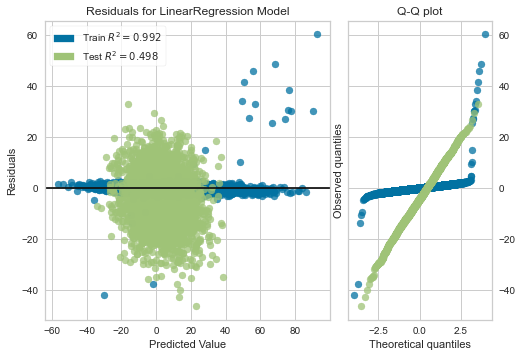

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [58]:
from yellowbrick.regressor import ResidualsPlot

# residuals plot
visualizer = ResidualsPlot(load_model,hist=False,qqplot=True)
visualizer.fit(X_train, Y_train)  # Fit the training data to the visualizer
visualizer.score(X_test3,Y_test1)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [59]:
#Y_pred1 = lr.predict(X_test1)
#lr.score(X_test1,Y_test1)
Y_pred1 = load_model.predict(X_test3)

load_model.score(X_test3,Y_test1)

0.49815051468242555

Text(0, 0.5, 'Actual')

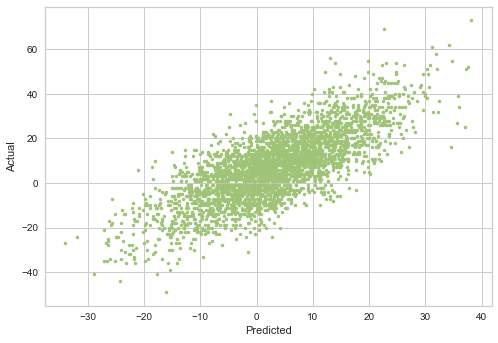

In [60]:
# Testing and plotting the actual vs predicted Marging of Victory
plt.plot(Y_pred1,Y_test1,'g.')
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [61]:
g_data9['Y_pred'] = Y_pred1 
g_data9

,attendance_x,lead_changes_x,times_tied_x,periods_x,h_3PM,h_3PA,h_2PM,h_2PA,h_FTM,h_FTA,h_Foul,h_TRB,h_AST,h_TO,h_STLA,h_BLKA,h_Ejection,h_Flagrant,a_3PM,a_3PA,a_2PM,a_2PA,a_FTM,a_FTA,a_Foul,a_TRB,a_AST,a_TO,a_STLA,a_BLKA,a_Ejection,a_Flagrant,a_div,h_div,height_h,weight_h,height_a,weight_a,MOV,Y_pred
game_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
b4451a02-26c5-4005-9ac8-b06c1f71e661,2277.0,3.0,2.0,2.0,4,7,11,26,3,6,9,26,8,16,12,5,0,0,2,11,9,19,9,17,5,17,6,15,12,2,0,0,2,1,75.764706,189.058824,78.333333,203.666667,-20.0,4.187496
d9cf6c1e-2125-4dbe-9c34-d0f8de911b10,4685.0,6.0,6.0,2.0,3,6,10,20,12,12,5,19,5,9,6,1,0,0,6,16,7,19,3,7,2,19,8,9,6,3,0,0,2,0,77.437500,205.250000,78.000000,211.000000,6.0,5.291212
c4e04822-4888-4ac1-b79f-183b9be8060f,4685.0,5.0,6.0,2.0,6,8,5,17,4,8,5,18,9,13,8,2,0,0,3,11,6,10,7,13,4,13,5,10,8,0,0,0,2,0,77.437500,205.250000,76.437500,193.437500,4.0,2.492270
ccf67704-32c7-4959-b5f8-318761a9ffef,4685.0,7.0,8.0,3.0,1,8,6,21,6,9,8,17,2,9,5,3,0,0,1,6,11,17,5,6,10,18,5,12,5,2,0,0,2,0,77.437500,205.250000,78.222222,202.944444,2.0,-9.510045
23ac6027-7c73-4acf-820c-b0d170ccf342,4685.0,0.0,0.0,2.0,7,11,6,17,6,8,5,17,10,13,10,0,0,0,4,8,5,17,2,4,4,17,5,13,10,1,0,0,2,0,77.533333,205.933333,77.882353,209.176471,19.0,12.444482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92f9a4e0-2201-430b-a5ba-986a01ce0db7,4518.0,8.0,6.0,2.0,5,10,6,15,2,5,5,21,5,16,12,1,0,0,4,10,6,20,4,6,5,18,4,7,2,1,0,0,2,0,77.896021,203.348289,77.714286,205.214286,14.0,-1.613766
e4e7bc05-c112-46bb-a45a-eb7adf454a74,2892.0,1.0,1.0,2.0,4,12,9,14,2,4,5,17,9,12,9,1,0,0,3,7,8,20,2,2,3,13,3,9,9,1,0,0,2,0,78.000000,210.333333,77.066667,202.333333,23.0,3.279289
36ced72a-9d6a-47fe-af0b-613f30ac69c0,2125.0,7.0,8.0,2.0,5,18,6,11,2,2,4,17,8,7,2,0,0,0,4,8,6,14,8,9,4,14,5,5,2,1,0,0,2,0,76.625000,194.687500,77.066667,202.333333,-5.0,-4.086119


In [62]:
#Game ID: d9cf6c1e-2125-4dbe-9c34-d0f8de911b10 -- Well predicted game
#Game ID:23ac6027-7c73-4acf-820c-b0d170ccf342 -- High Scoring and large MOV with low prediction

In [63]:
#pbp_data2=pbp_data[(pbp_data["team_id"].notnull())&(pbp_data["game_id"]=='d9cf6c1e-2125-4dbe-9c34-d0f8de911b10')].compute()
pbp_data2=pbp_data[(pbp_data["team_id"].notnull())&(pbp_data["game_id"]=='23ac6027-7c73-4acf-820c-b0d170ccf342')].compute()

In [64]:
def get_timed_data(pbp_timed,seconds):
    return (pbp_timed[pbp_timed['elapsed_time_sec'] <= seconds])

In [65]:
%%time
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler

Y_pred2 = []
for i in range(60,2400,60):
    pbp_data3 = get_timed_data(pbp_data2,i)
    pbp_data3["2PA"]=(pbp_data3["event_type"].isin(["twopointmade","twopointmiss"]))
    pbp_data3["2PM"]=(pbp_data3["event_type"]=="twopointmade")
    pbp_data3["3PA"]=(pbp_data3["event_type"]=="threepointmade")|(pbp_data3["event_type"]=="threepointmiss")
    pbp_data3["3PM"]=(pbp_data3["event_type"]=="threepointmade")
    pbp_data3["FTA"]=(pbp_data3["event_type"]=="freethrowmade")|(pbp_data3["event_type"]=="freethrowmiss")
    pbp_data3["FTM"]=(pbp_data3["event_type"]=="freethrowmade")
    pbp_data3["TRB"]=(pbp_data3["event_type"]=="rebound")
    pbp_data3["TO"]=(pbp_data3["event_type"]=="turnover")
    pbp_data3["Foul"]=(pbp_data3["event_type"].isin(["flagrantone","flagranttwo","clearpathfoul","technicalfoul",\
                                                    "minortechnicalfoul","personalfoul","defensivethreeseconds"]))
    pbp_data3["Flagrant"]=(pbp_data3["event_type"].isin(["flagrantone","flagranttwo"]))
    pbp_data3["Ejection"]=(pbp_data3["event_type"]=="ejection")
    pbp_data3["AST"] =pbp_data2.apply(checkast,axis=1)
    pbp_data3["STLA"] =pbp_data2.apply(checkstl,axis=1)
    pbp_data3["BLKA"] = pbp_data2.apply(checkblk,axis=1)
    pbp_data4 = pbp_data3.groupby(["game_id","team_id"]).agg({'2PA':'sum','2PM':'sum','3PA':'sum','3PM':'sum','FTA':'sum',\
                                                         'FTM':'sum','TRB':'sum','TO':'sum','Foul':'sum','Flagrant':'sum',\
                                                         'Ejection':'sum','AST':'sum','STLA':'sum','BLKA':'sum'})
    
    g_data1 = g_data[feature_subset]
    g_data2 = g_data1.merge(pbp_data4.add_prefix('h_'),how='inner',left_on=['game_id','h_id'],right_on=['game_id','team_id'])
    g_data3 = g_data2.merge(pbp_data4.add_prefix('a_'),how='inner',left_on=['game_id','a_id'],right_on=['game_id','team_id'])
    g_data4 = g_data3.set_index(['game_id'],verify_integrity=True)
    g_data5 = g_data4.drop(columns=['h_id', 'a_id', 'season', 'conference_game', 'tournament',
           'tournament_type', 'tournament_round', 'tournament_game_no','venue_id', 'venue_city', 'venue_state','venue_address', 	'venue_zip', 'venue_capacity',
           'MOV', 'h_market', 'h_conf_id', 'h_conf_name', 'h_division_alias',
           'h_points_game', 'a_market', 'a_conf_id', 'a_conf_name',
           'a_division_alias', 'a_points_game'])
    g_data6 = g_data5[cols]
    g_data7 = g_data6.merge(cln_new, how='inner', on=['game_id'])
    g_data8 = g_data7.drop(columns=['attendance_y','lead_changes_y', 'times_tied_y', 'periods_y', 'h_three_points_made',
           'h_three_points_att', 'h_two_points_made', 'h_two_points_att','h_free_throws_made', 'h_free_throws_att', 
           'h_personal_fouls','h_rebounds', 'h_assists', 'h_turnovers', 'h_steals', 'h_blocks',
           'h_ejections', 'h_flagrant_fouls', 'a_three_points_made','a_three_points_att', 'a_two_points_made', 
           'a_two_points_att','a_free_throws_made', 'a_free_throws_att', 'a_personal_fouls',
           'a_rebounds', 'a_assists', 'a_turnovers', 'a_steals', 'a_blocks','a_ejections', 'a_flagrant_fouls'])
    g_data9 = g_data8.merge(pd.DataFrame(Y_test), on='game_id', how='inner')
    
    Y_test1 = g_data9['MOV'].fillna(0)
    X_test1 = g_data9.drop(columns=['MOV']).fillna(0)
    X_test1['periods_x'] = 1
    X_test2 = pca.transform(X_test1.to_numpy())
    #X_test3 = X_test2.compute()

    Y_pred2.append(load_model.predict(X_test2))
    #load_model.score(X_test3,Y_test1)


Wall time: 11.4 s


list

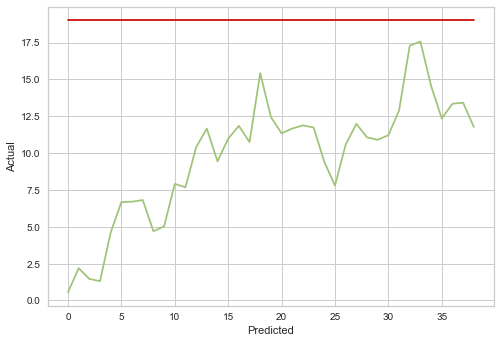

In [84]:
plt.plot(Y_pred2,'g-')
plt.plot([Y_test1]*len(Y_pred2),'r-')
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [67]:
df.shape

(11058, 57)

In [68]:
df["season"].unique()

array([2015., 2013., 2014., 2017., 2016.])

In [69]:
#Checking how many games are tournament
df['tournament'].unique()

array([nan, 'NCAA', 'Conference'], dtype=object)

In [70]:
df['tournament_type'].unique()

array([nan, 'South Regional', 'West Regional', 'Midwest Regional',
       'East Regional', 'SCAR Bracket', 'Pac', 'CBI', 'Ohio Valley',
       'CIT', 'Missouri Valley', 'Horizon League', 'Valparaiso Bracket',
       'Final Four', 'Big 12', 'Sun Belt', 'Big South', 'Big Sky',
       'American Athletic', 'Southern', 'Summit League', 'Big West',
       'Vegas 16', 'Conference USA', 'Southland', 'First Four', 'MEAC',
       'ACC', 'National Championship', 'SBON Bracket', 'Atlantic Sun',
       'Monmouth Bracket', 'Patriot League', 'Mountain West',
       'Southeastern', 'Mid', 'Big Ten', 'America East', 'Northeast',
       'Colonial Athletic', 'MAAC', 'Colorado St. Bracket',
       'Old Dominion Bracket', 'Temple Bracket', 'Richmond Bracket',
       'SWAC', 'Atlantic Coast', 'SEC', 'California Bracket',
       'Illinois St Bracket', 'Iowa Bracket', 'Syracuse Bracket',
       'Southwest Athletic', 'Ivy League', 'Atlantic 10',
       'Metro Atlantic', 'NIT', 'Big East', 'Western Athletic',
 

In [71]:
#client.close()